# 

In [1]:
!apt update -y

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:2 http://security.ubuntu.com/ubuntu jammy-security InRelease            
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease                  
Hit:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
All packages are up to date.


In [2]:
!apt upgrade -y

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Calculating upgrade... Done
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.


In [3]:
!apt upgrade libnccl2 -y --allow-change-held-packages

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libnccl2 is already the newest version (2.22.3-1+cuda12.6).
Calculating upgrade... Done
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.


In [4]:
!git clone https://github.com/zhouhaoyi/ETDataset.git

fatal: destination path 'ETDataset' already exists and is not an empty directory.


In [5]:
!pip install -U pandas==2.2.2 numpy==1.26.4 matplotlib pyarrow==17.0.0 scikit-learn==1.5.1 tkan==0.4.1 "jax[cuda12]"==0.4.30 nvidia-cublas-cu12==12.5.3.2 nvidia-cuda-cupti-cu12==12.5.82 nvidia-cuda-nvcc-cu12==12.5.82 nvidia-cuda-runtime-cu12==12.5.82 nvidia-nvjitlink-cu12==12.5.82 nvidia-cusolver-cu12==11.6.3.83 nvidia-cusparse-cu12==12.5.1.3 nvidia-cufft-cu12==11.2.3.61 temporal_linear_network

In [6]:
import os
BACKEND = 'jax' # You can use any backend here 
os.environ['KERAS_BACKEND'] = BACKEND

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

import keras
from keras.models import Sequential


from sklearn.metrics import r2_score, root_mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

from tln import TLN

import time

keras.utils.set_random_seed(42) 

N_MAX_EPOCHS = 1000
BATCH_SIZE = 128
early_stopping_callback = lambda : keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.00001,
    patience=10,
    mode="min",
    restore_best_weights=True,
    start_from_epoch=6,
)
lr_callback = lambda : keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.25,
    patience=5,
    mode="min",
    min_delta=0.00001,
    min_lr=0.000025,
    verbose=0,
)
callbacks = lambda : [early_stopping_callback(), lr_callback(), keras.callbacks.TerminateOnNaN()]


In [7]:
def plot_weights(weights, name, savefig=True):
    fig, axes = plt.subplots(2, 2, figsize=(20, 20))
    axes = axes.flatten()
    
    cmap = plt.get_cmap('RdBu_r')
    
    for i in range(4):
        idx = i * 32
        subplot_weights = weights[:, :, idx]
        vmax = np.abs(subplot_weights).max()
        vmin = -vmax
        
        linthresh = vmax / 100  # Adjust this value to control the emphasis on small values
        norm = SymLogNorm(linthresh=linthresh, linscale=1, vmin=vmin, vmax=vmax)
        
        im = axes[i].imshow(subplot_weights, cmap=cmap, norm=norm, aspect='auto')
        axes[i].set_title(f'Output Step {idx}')
        axes[i].set_xlabel('Input Features')
        axes[i].set_ylabel('Input Sequence')
        
        # Add colorbar for each subplot
        divider = make_axes_locatable(axes[i])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbar = fig.colorbar(im, cax=cax, orientation='vertical')
        cbar.set_label('Weight Value')
    
    plt.tight_layout()
    
    plt.suptitle(f'{name} Weights Heatmap', fontsize=16, y=1.02)
    if savefig:
        plt.savefig(f'/plots/{name}.png', bbox_inches='tight', dpi=300)
    plt.show()

In [8]:
def linear_regression_weights_and_model(X_train, y_train):
    n_elements, sequence_length, features = X_train.shape
    X_reshaped = X_train.reshape(n_elements, -1)
    y_reshaped = y_train.squeeze()
    
    model = LinearRegression()
    model.fit(X_reshaped, y_reshaped)
    
    weights = model.coef_.T.reshape(sequence_length, features, -1)
    bias = model.intercept_
    
    return weights, bias, model

In [9]:
def ridge_regression_weights_and_model(X_train, y_train, alpha=1.0):
    n_elements, sequence_length, features = X_train.shape
    X_reshaped = X_train.reshape(n_elements, -1)
    y_reshaped = y_train.squeeze()
    
    model = Ridge(alpha=alpha)
    model.fit(X_reshaped, y_reshaped)
    
    weights = model.coef_.T.reshape(sequence_length, features, -1)
    bias = model.intercept_
    
    return weights, bias, model

In [10]:
def lasso_regression_weights_and_model(X_train, y_train, alpha=1.0):
    n_elements, sequence_length, features = X_train.shape
    X_reshaped = X_train.reshape(n_elements, -1)
    y_reshaped = y_train.squeeze()
    
    model = Lasso(alpha=alpha, precompute=True, max_iter = 10000, selection='random')
    model.fit(X_reshaped, y_reshaped)
    
    weights = model.coef_.reshape(sequence_length, features, -1)
    bias = model.intercept_
    
    return weights, bias, model

In [11]:
def elasticnet_regression_weights_and_model(X_train, y_train, alpha=1.0, l1_ratio=0.5):
    n_elements, sequence_length, features = X_train.shape
    X_reshaped = X_train.reshape(n_elements, -1)
    y_reshaped = y_train.squeeze()
    
    model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, precompute=True, max_iter = 10000, selection='random')
    model.fit(X_reshaped, y_reshaped)
    
    weights = model.coef_.reshape(sequence_length, features, -1)
    bias = model.intercept_
    
    return weights, bias, model

# ETTh1 Dataset

In [12]:

def get_hourly_dataset(path = 'ETDataset/ETT-small/ETTh1.csv', input_steps = 96, output_steps = 24, mode = "S", add_time_information=False):
    # Load the ETT dataset
    df = pd.read_csv(path)

    if add_time_information:
        df['date'] = pd.to_datetime(df['date'])
        df['hour'] = df['date'].apply(lambda x: x.hour)
        df['dayofweek'] = df['date'].apply(lambda x: x.dayofweek)
    
    # Assume 'OT' (oil temperature) is the target variable
    target_col = ['OT'] if "S" in mode else df.columns[1:]
    feature_cols = ['OT'] if mode=="S" else df.columns[1:]
    
    # Prepare the data
    X = df[feature_cols].values
    y = df[target_col].values
    
    border1s = [0, 12*30*24 - input_steps, 12*30*24+4*30*24 - input_steps]
    border2s = [12*30*24, 12*30*24+4*30*24, 12*30*24+8*30*24]
    
    # Split the data first
    X_train, X_test, y_train, y_test = X[border1s[0]:border2s[1]], X[border1s[1]:border2s[2]], y[border1s[0]:border2s[1]], y[border1s[1]:border2s[2]]
    
    # Initialize scalers
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    
    # Fit and transform the training data
    X_train_scaled = scaler_X.fit_transform(X_train)
    y_train_scaled = scaler_y.fit_transform(y_train)
    
    # Transform the test data
    X_test_scaled = scaler_X.transform(X_test)
    y_test_scaled = scaler_y.transform(y_test)
    
    # Create sequences with multi-horizon outputs
    def create_sequences(X, y, input_steps, output_steps):
        Xs, ys = [], []
        for i in range(len(X) - input_steps - output_steps + 1):
            Xs.append(X[i:(i + input_steps)])
            ys.append(y[(i + input_steps):(i + input_steps + output_steps)])
        return np.array(Xs), np.array(ys)
    
    
    # Create sequences for training and test sets separately
    X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, input_steps, output_steps)
    X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, input_steps, output_steps)
    if "S" in mode:
        y_train_seq, y_test_seq = np.squeeze(y_train_seq), np.squeeze(y_test_seq)
    return X_train_seq, y_train_seq, X_test_seq, y_test_seq

In [13]:
sequence_length, n_ahead = 1000, 128
X_train, y_train, X_test, y_test = get_hourly_dataset(input_steps = sequence_length, output_steps = n_ahead, mode = 'MS', add_time_information = True) 
y_train, y_test = np.expand_dims(y_train, axis=-1), np.expand_dims(y_test, axis=-1)

In [14]:
X_train.shape, y_train.shape

((10393, 1000, 9), (10393, 128, 1))

177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 862us/step
r2 score: 0.7409153307568302 took 8.532323837280273 seconds


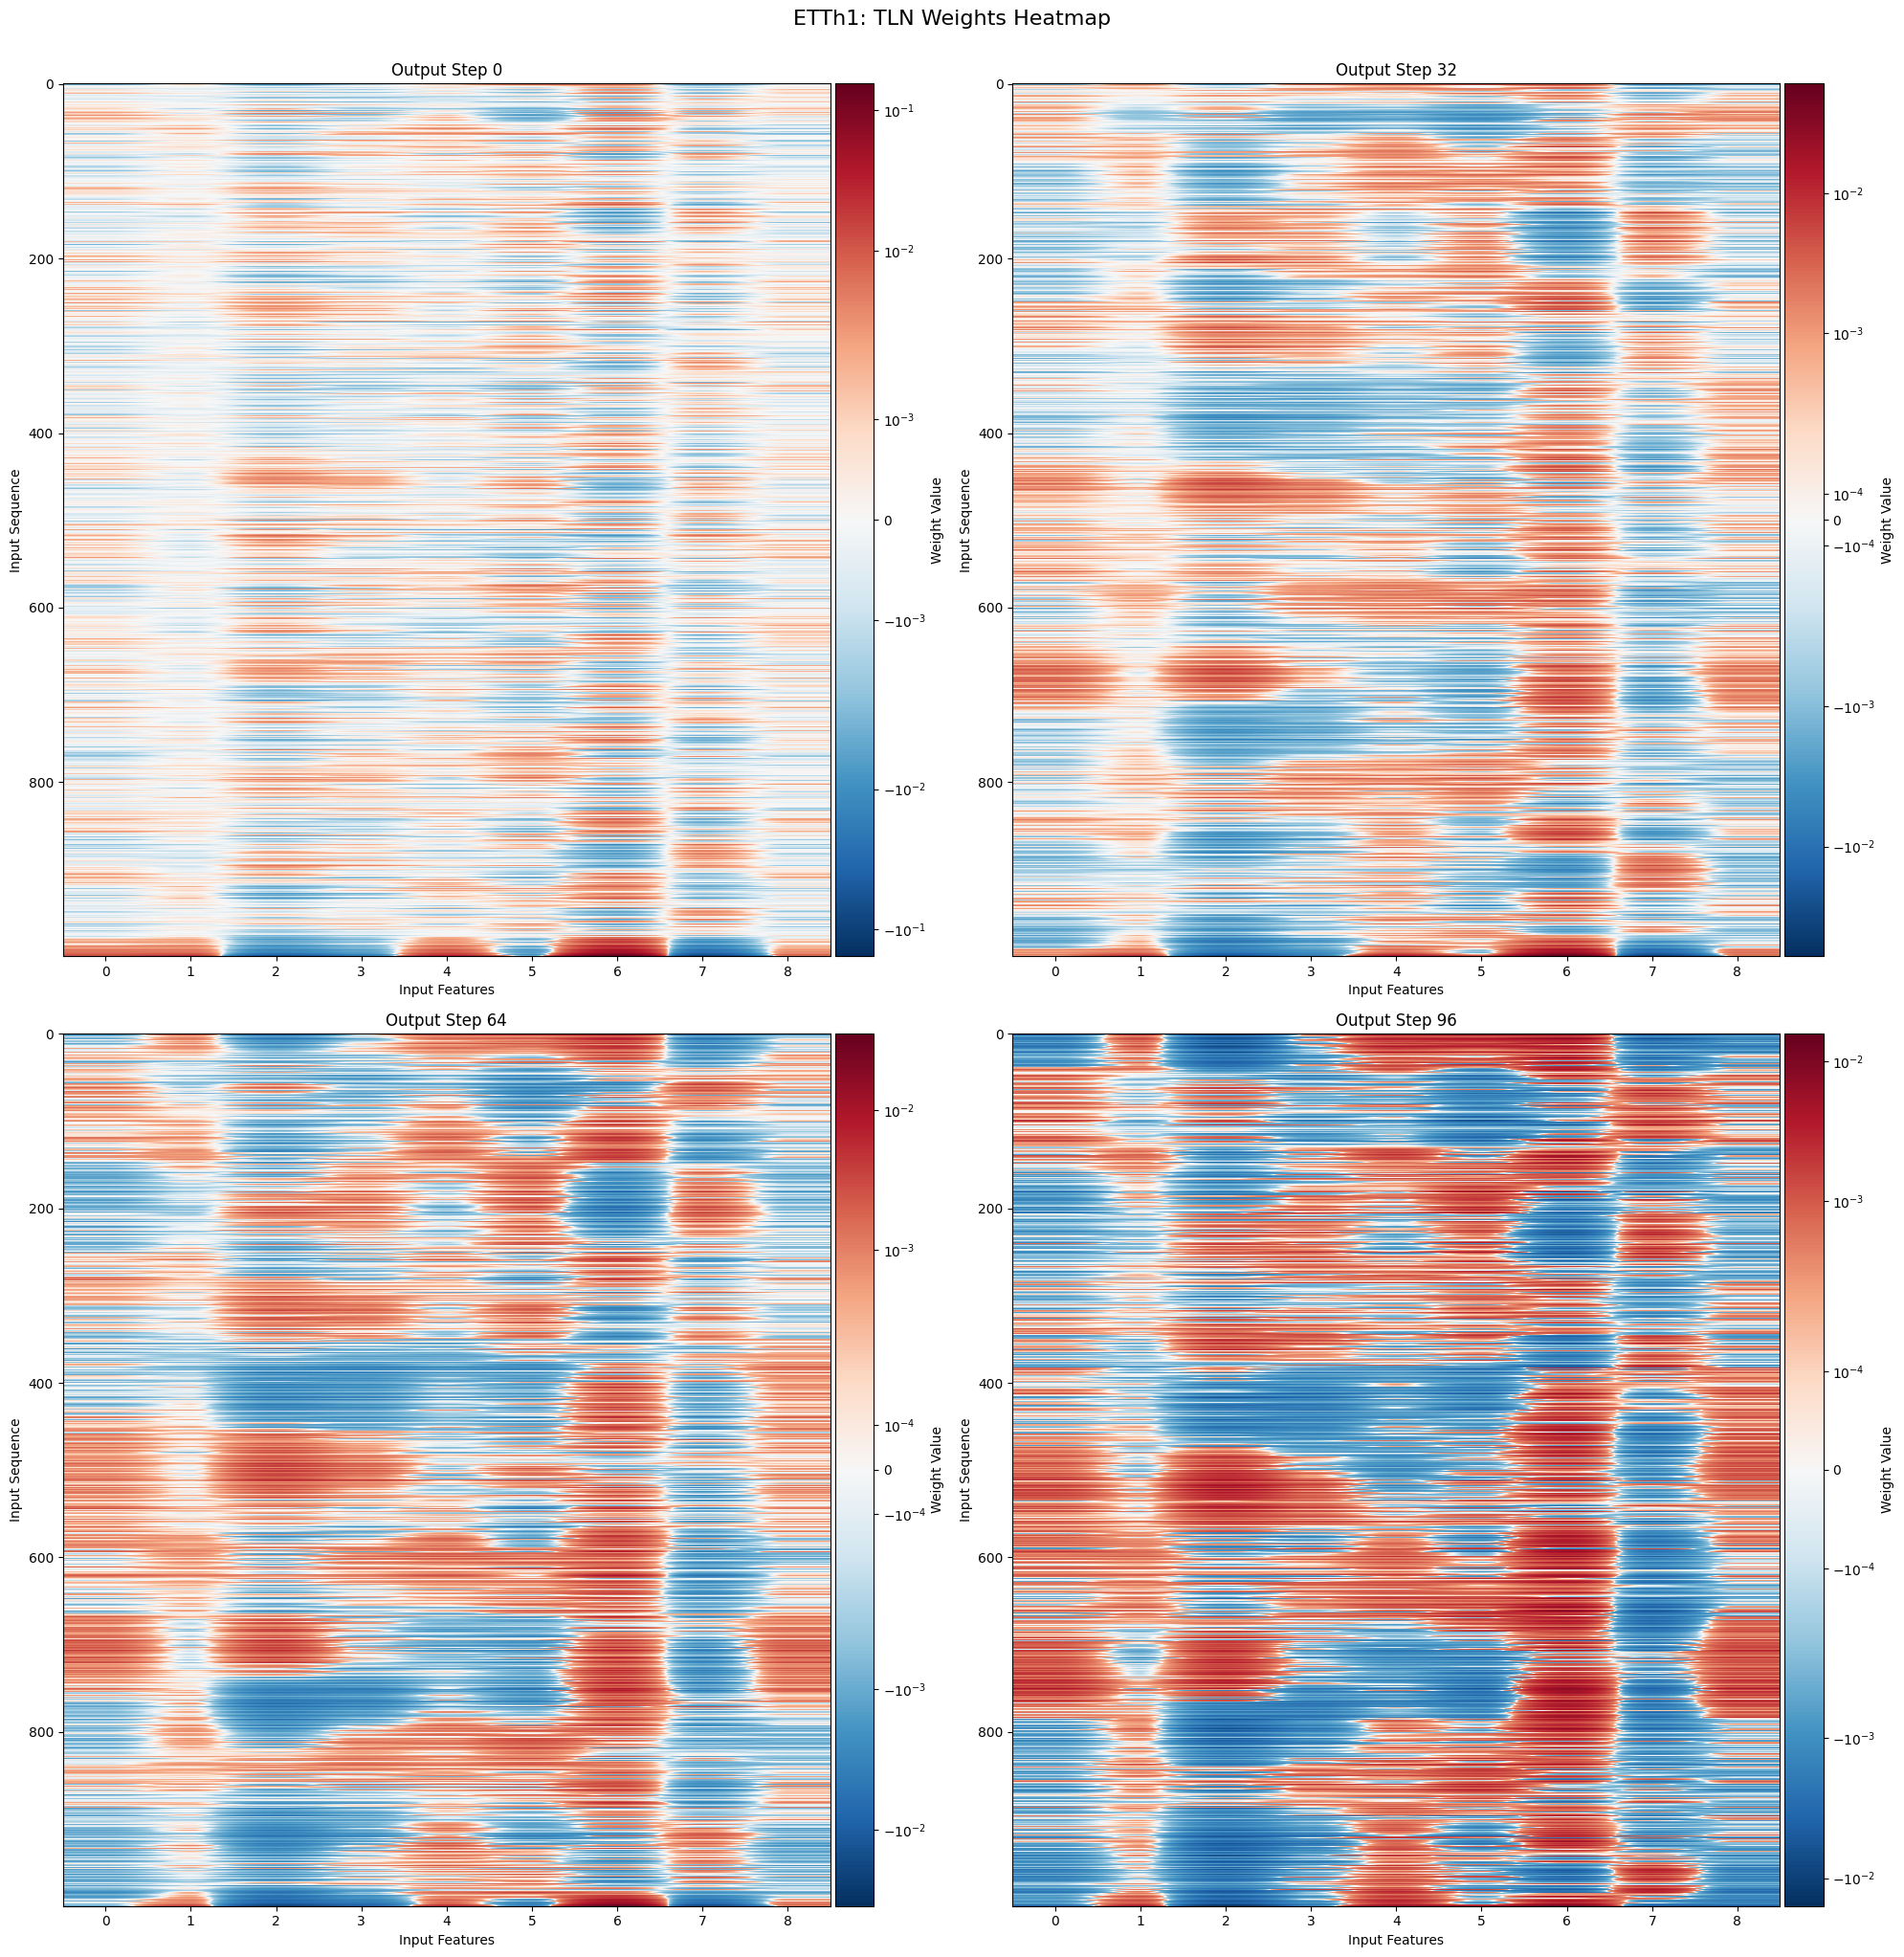

In [15]:
model = TLN(
    output_len = n_ahead,
    output_features = 1,
    flatten_output = False,
    hidden_layers = 2,
    use_convolution = True,
)
model.build(X_train.shape)

optimizer = keras.optimizers.Adam(0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error', jit_compile=True)

start_time = time.time()
history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=N_MAX_EPOCHS, validation_split=0.2, callbacks=callbacks(), shuffle=True, verbose=False)
end_time = time.time()
preds = model.predict(X_test)
print('r2 score:', r2_score(y_true=y_test.flatten(), y_pred=preds.flatten()), 'took', end_time - start_time, 'seconds')
weights, bias = model.compute_linear_equivalent_weights()
plot_weights(weights, 'ETTh1: TLN')

r2 score: 0.661645526946647 took 143.42849373817444 seconds


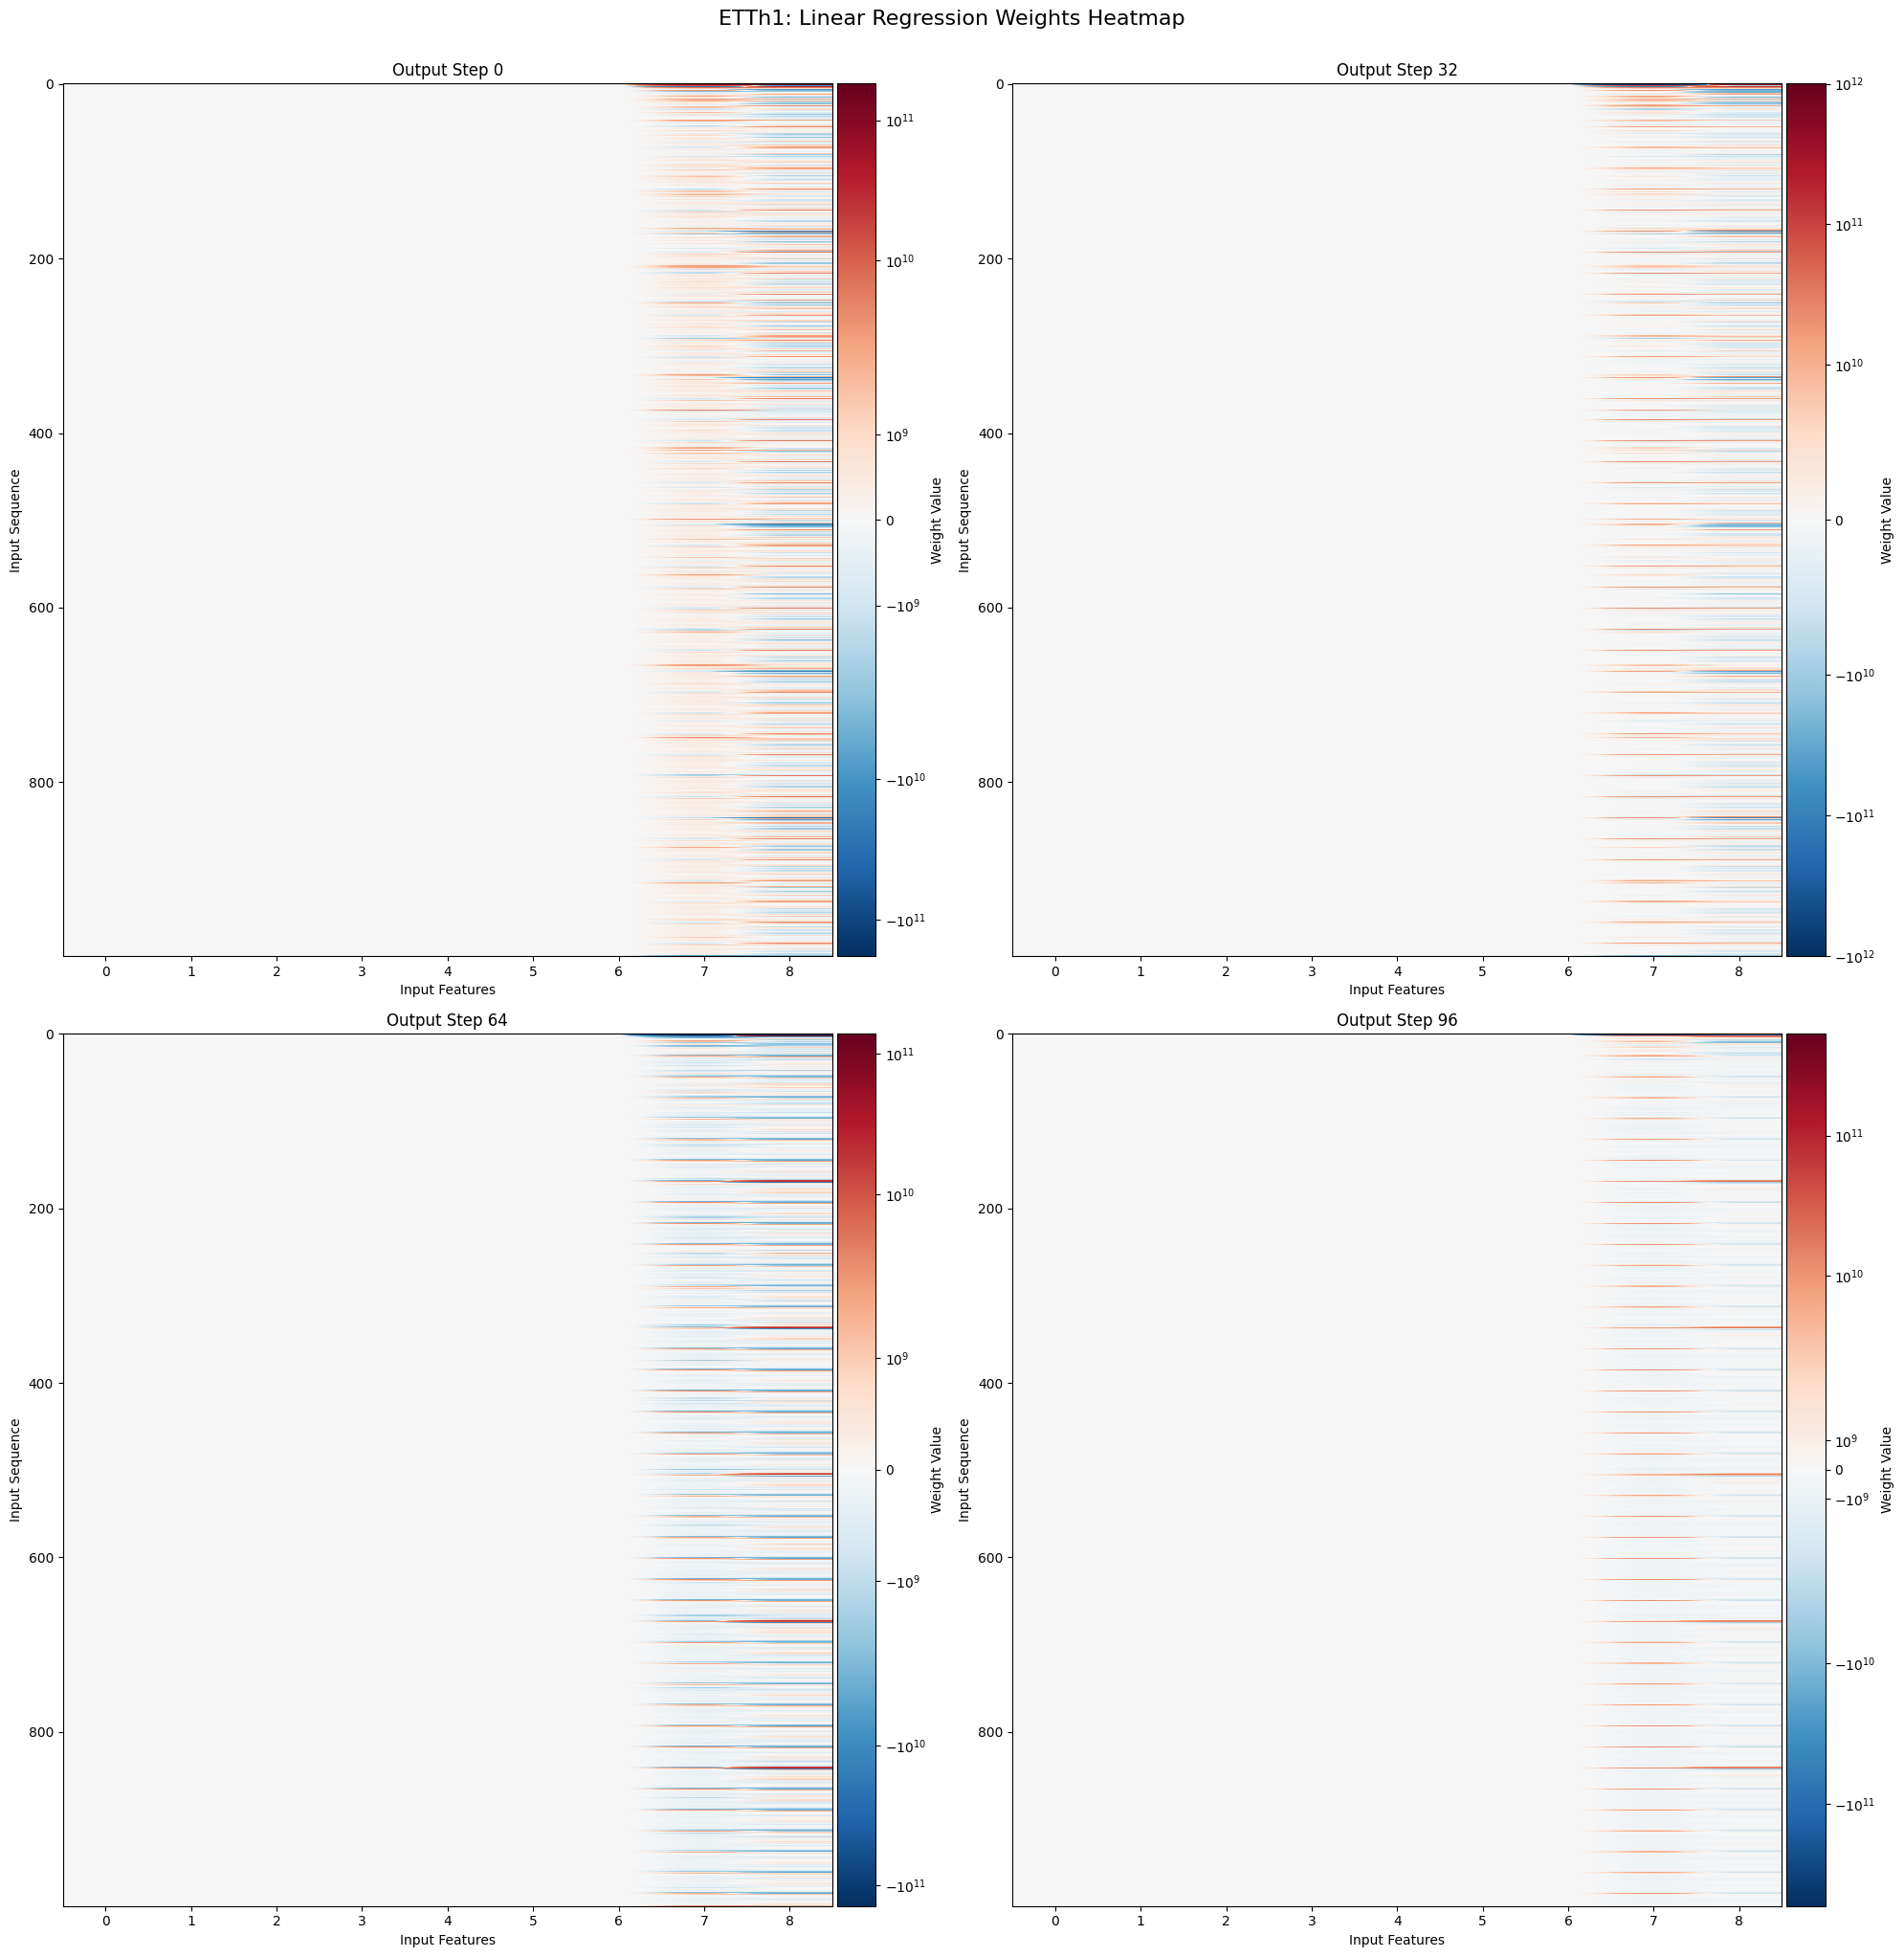

In [16]:
start_time = time.time()
weights, bias, model = linear_regression_weights_and_model(X_train, y_train)
end_time = time.time()
preds = model.predict(X_test.reshape(X_test.shape[0], -1))
print('r2 score:', r2_score(y_true=y_test.flatten(), y_pred=preds.flatten()), 'took', end_time - start_time, 'seconds')

plot_weights(weights, 'ETTh1: Linear Regression')

r2 score: 0.6699834397857873 took 2.413865089416504 seconds


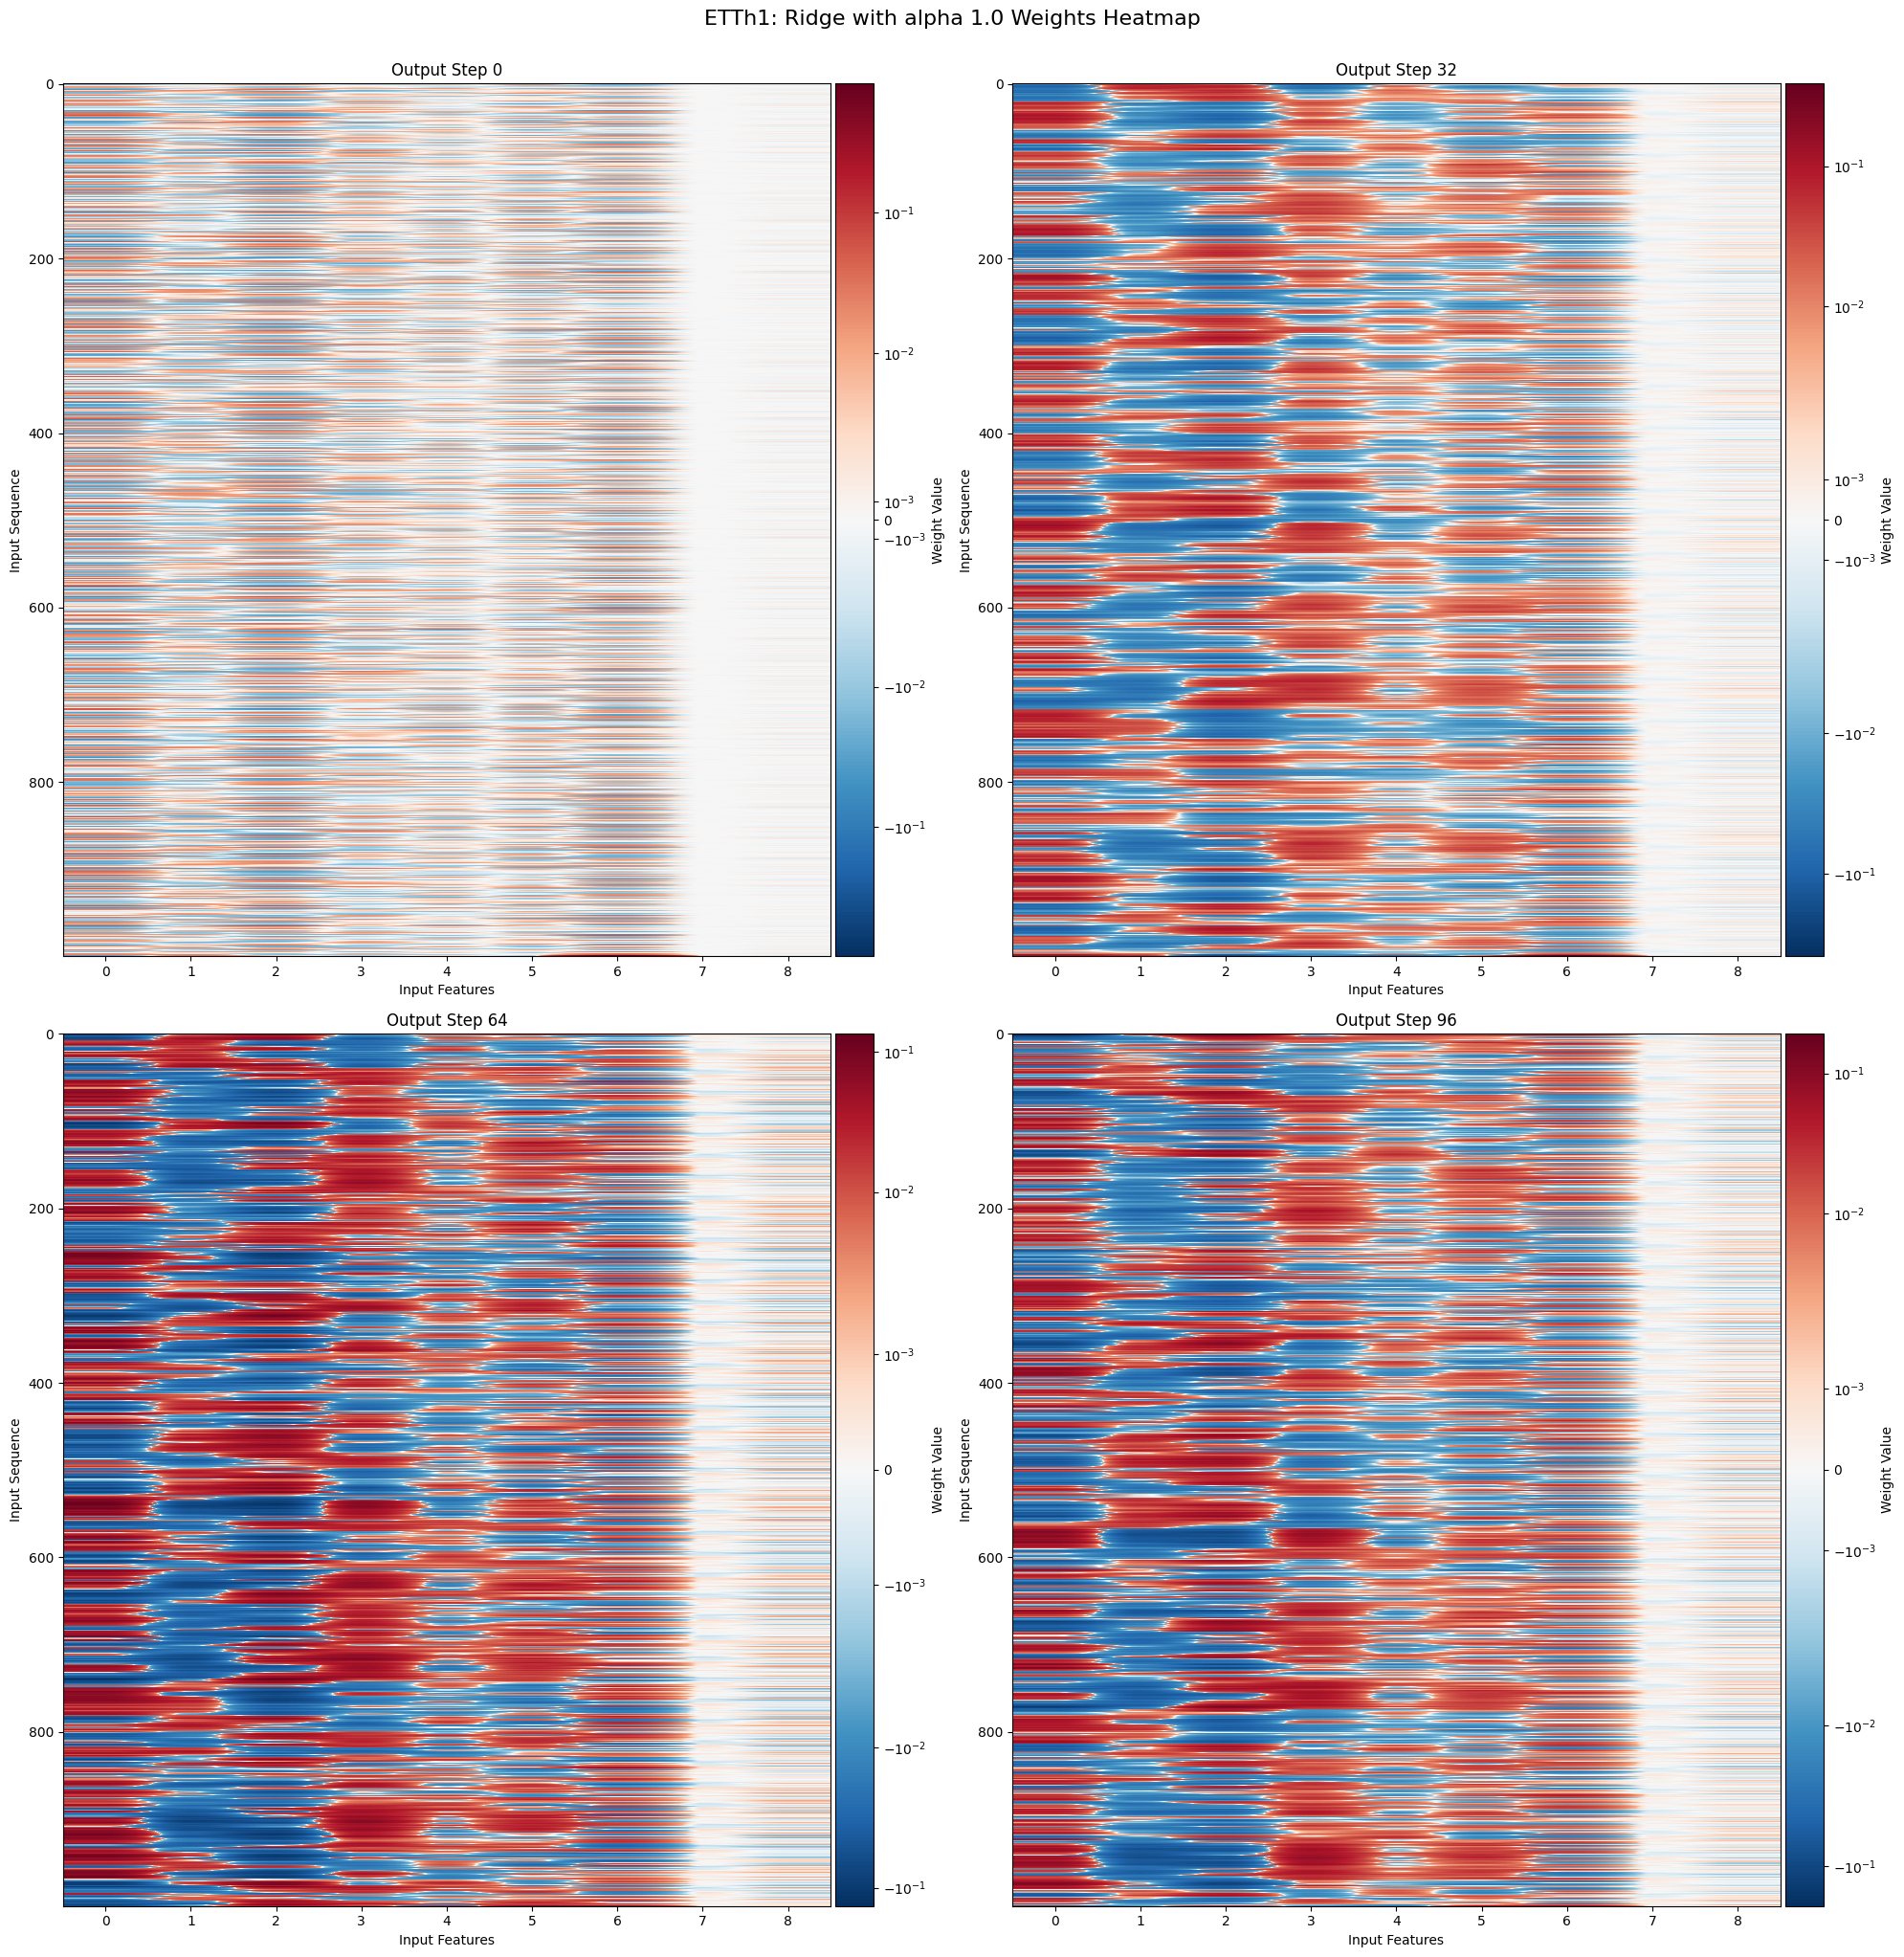

In [17]:
alpha = 1.
start_time = time.time()
weights, bias, model = ridge_regression_weights_and_model(X_train, y_train, alpha = alpha)
end_time = time.time()
preds = model.predict(X_test.reshape(X_test.shape[0], -1))
print('r2 score:', r2_score(y_true=y_test.flatten(), y_pred=preds.flatten()), 'took', end_time - start_time, 'seconds')

plot_weights(weights, f'ETTh1: Ridge with alpha {alpha}')

r2 score: 0.8462839363628307 took 95.29938459396362 seconds


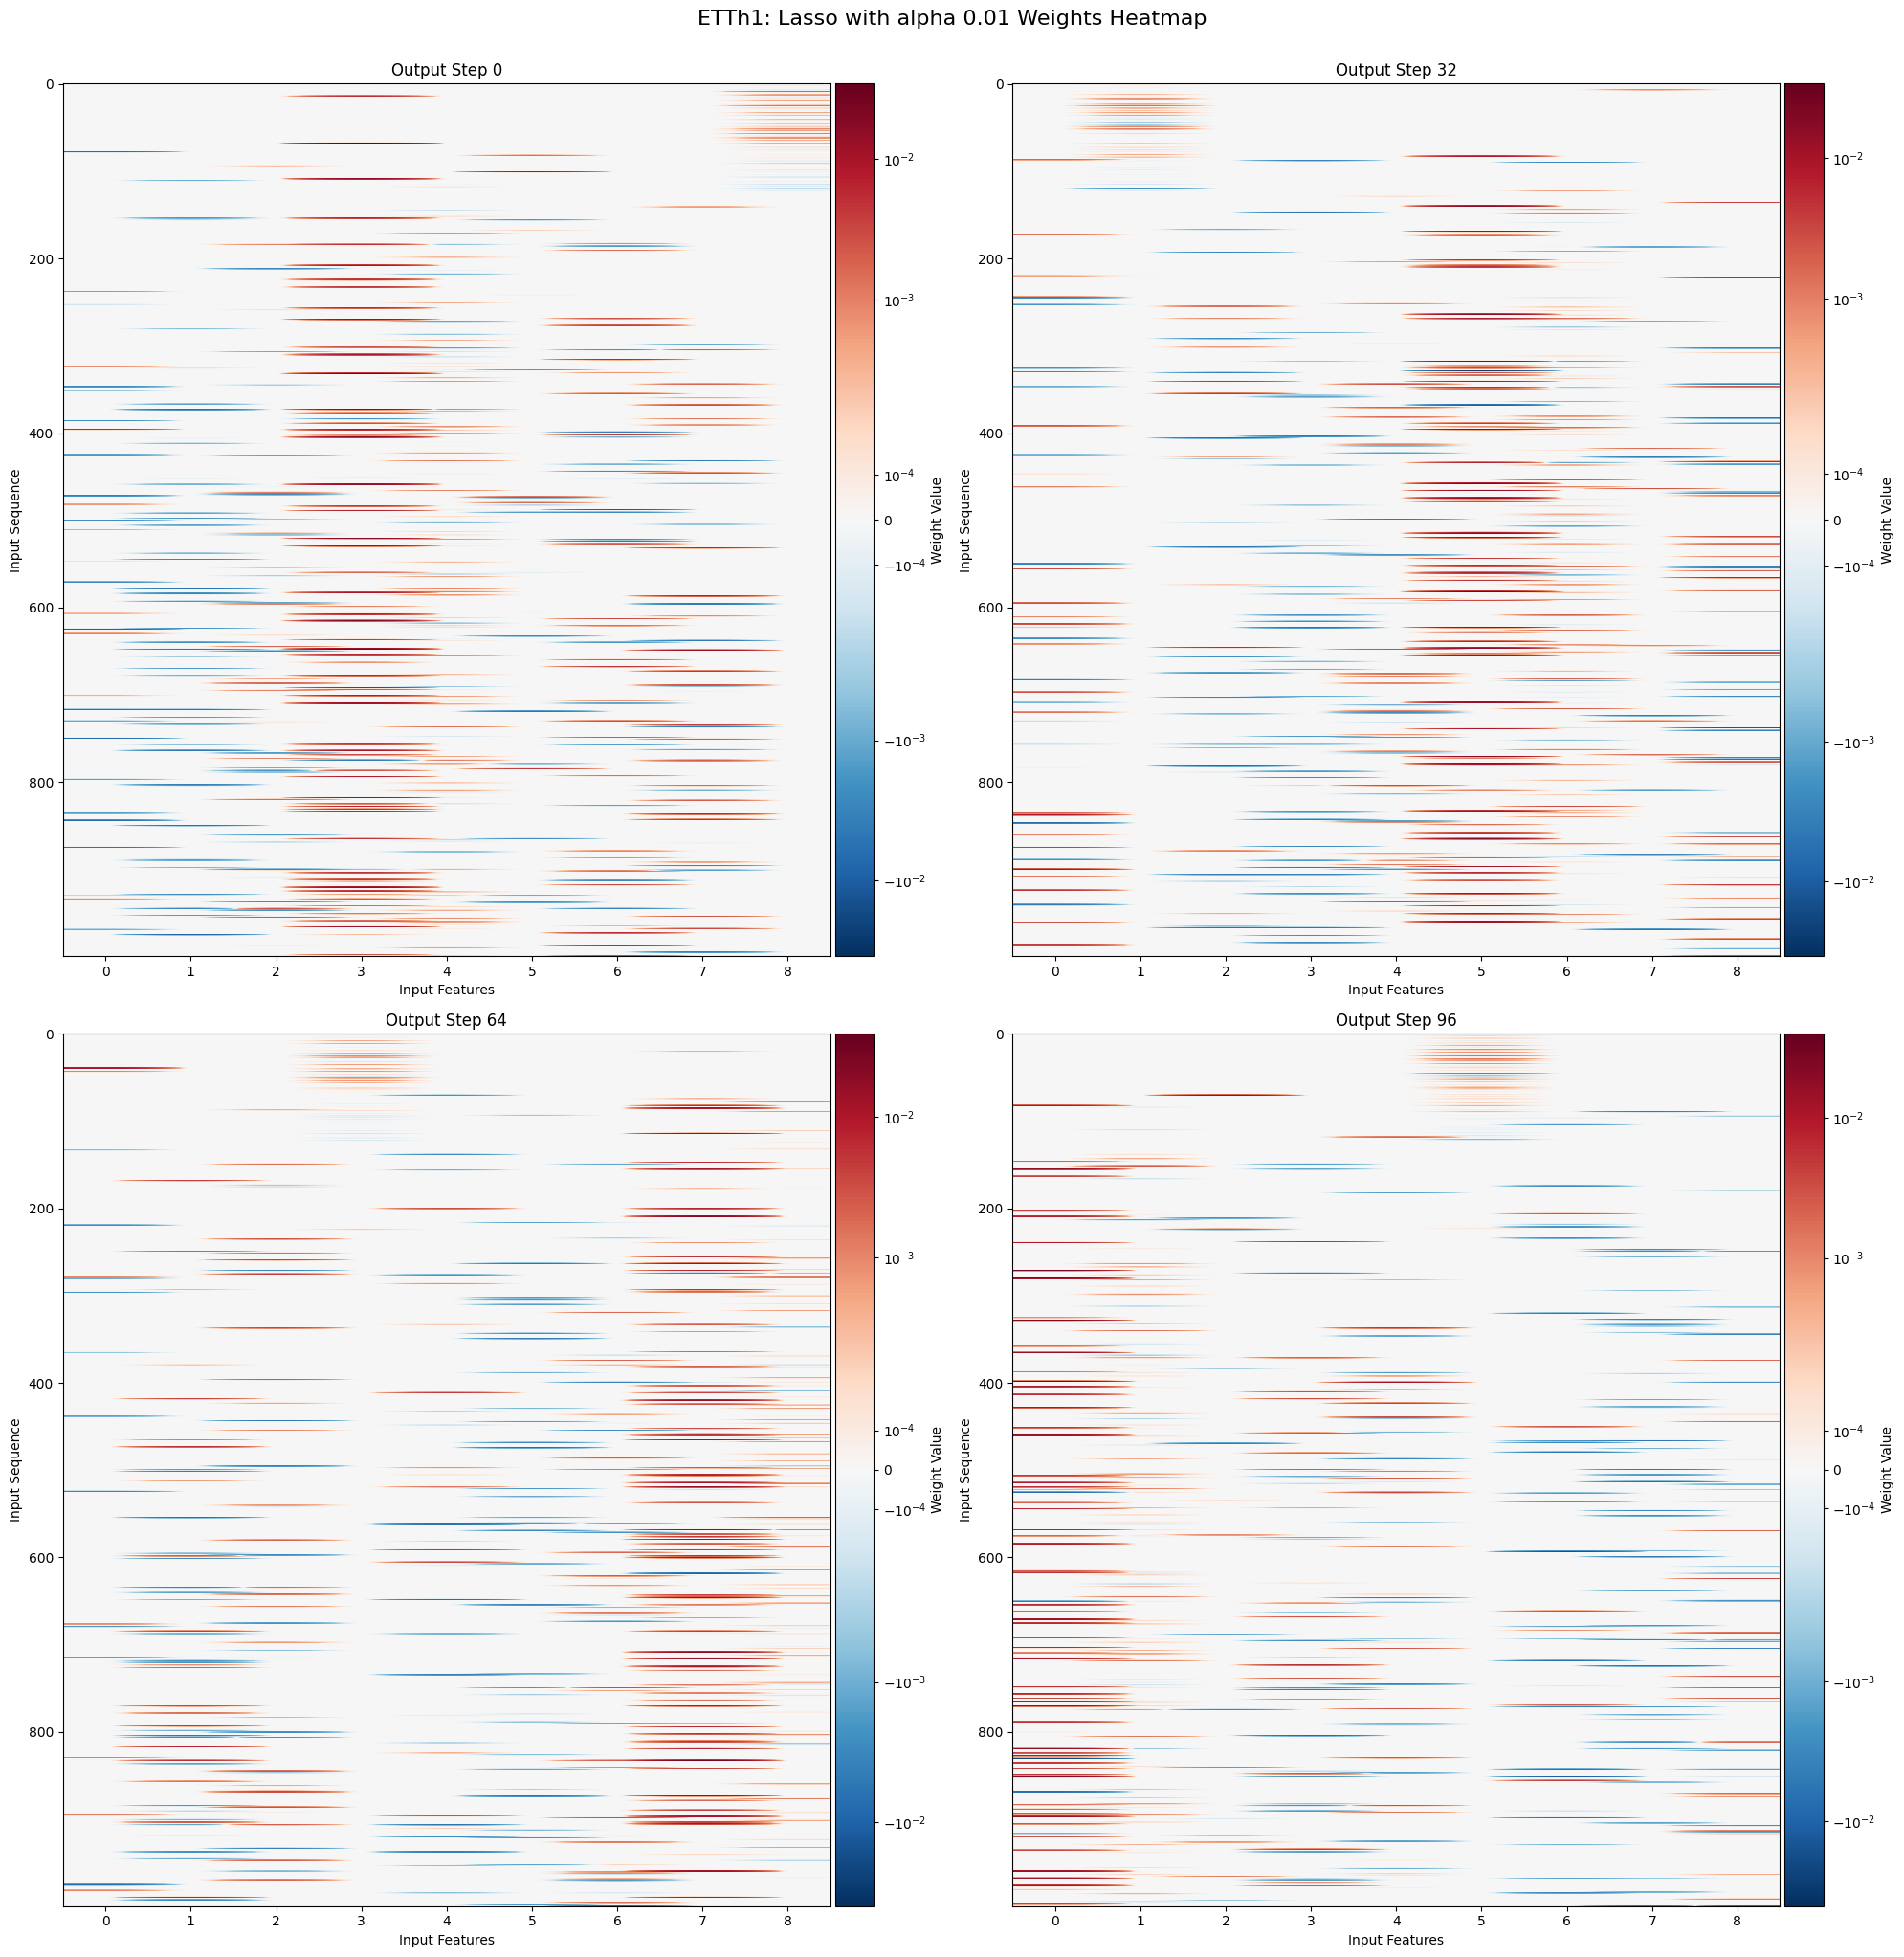

In [18]:
alpha = 1e-2
start_time = time.time()
weights, bias, model = lasso_regression_weights_and_model(X_train, y_train, alpha = alpha)
end_time = time.time()
preds = model.predict(X_test.reshape(X_test.shape[0], -1))
print('r2 score:', r2_score(y_true=y_test.flatten(), y_pred=preds.flatten()), 'took', end_time - start_time, 'seconds')

plot_weights(weights, f'ETTh1: Lasso with alpha {alpha}')

r2 score: 0.8590117832834373 took 133.47310161590576 seconds


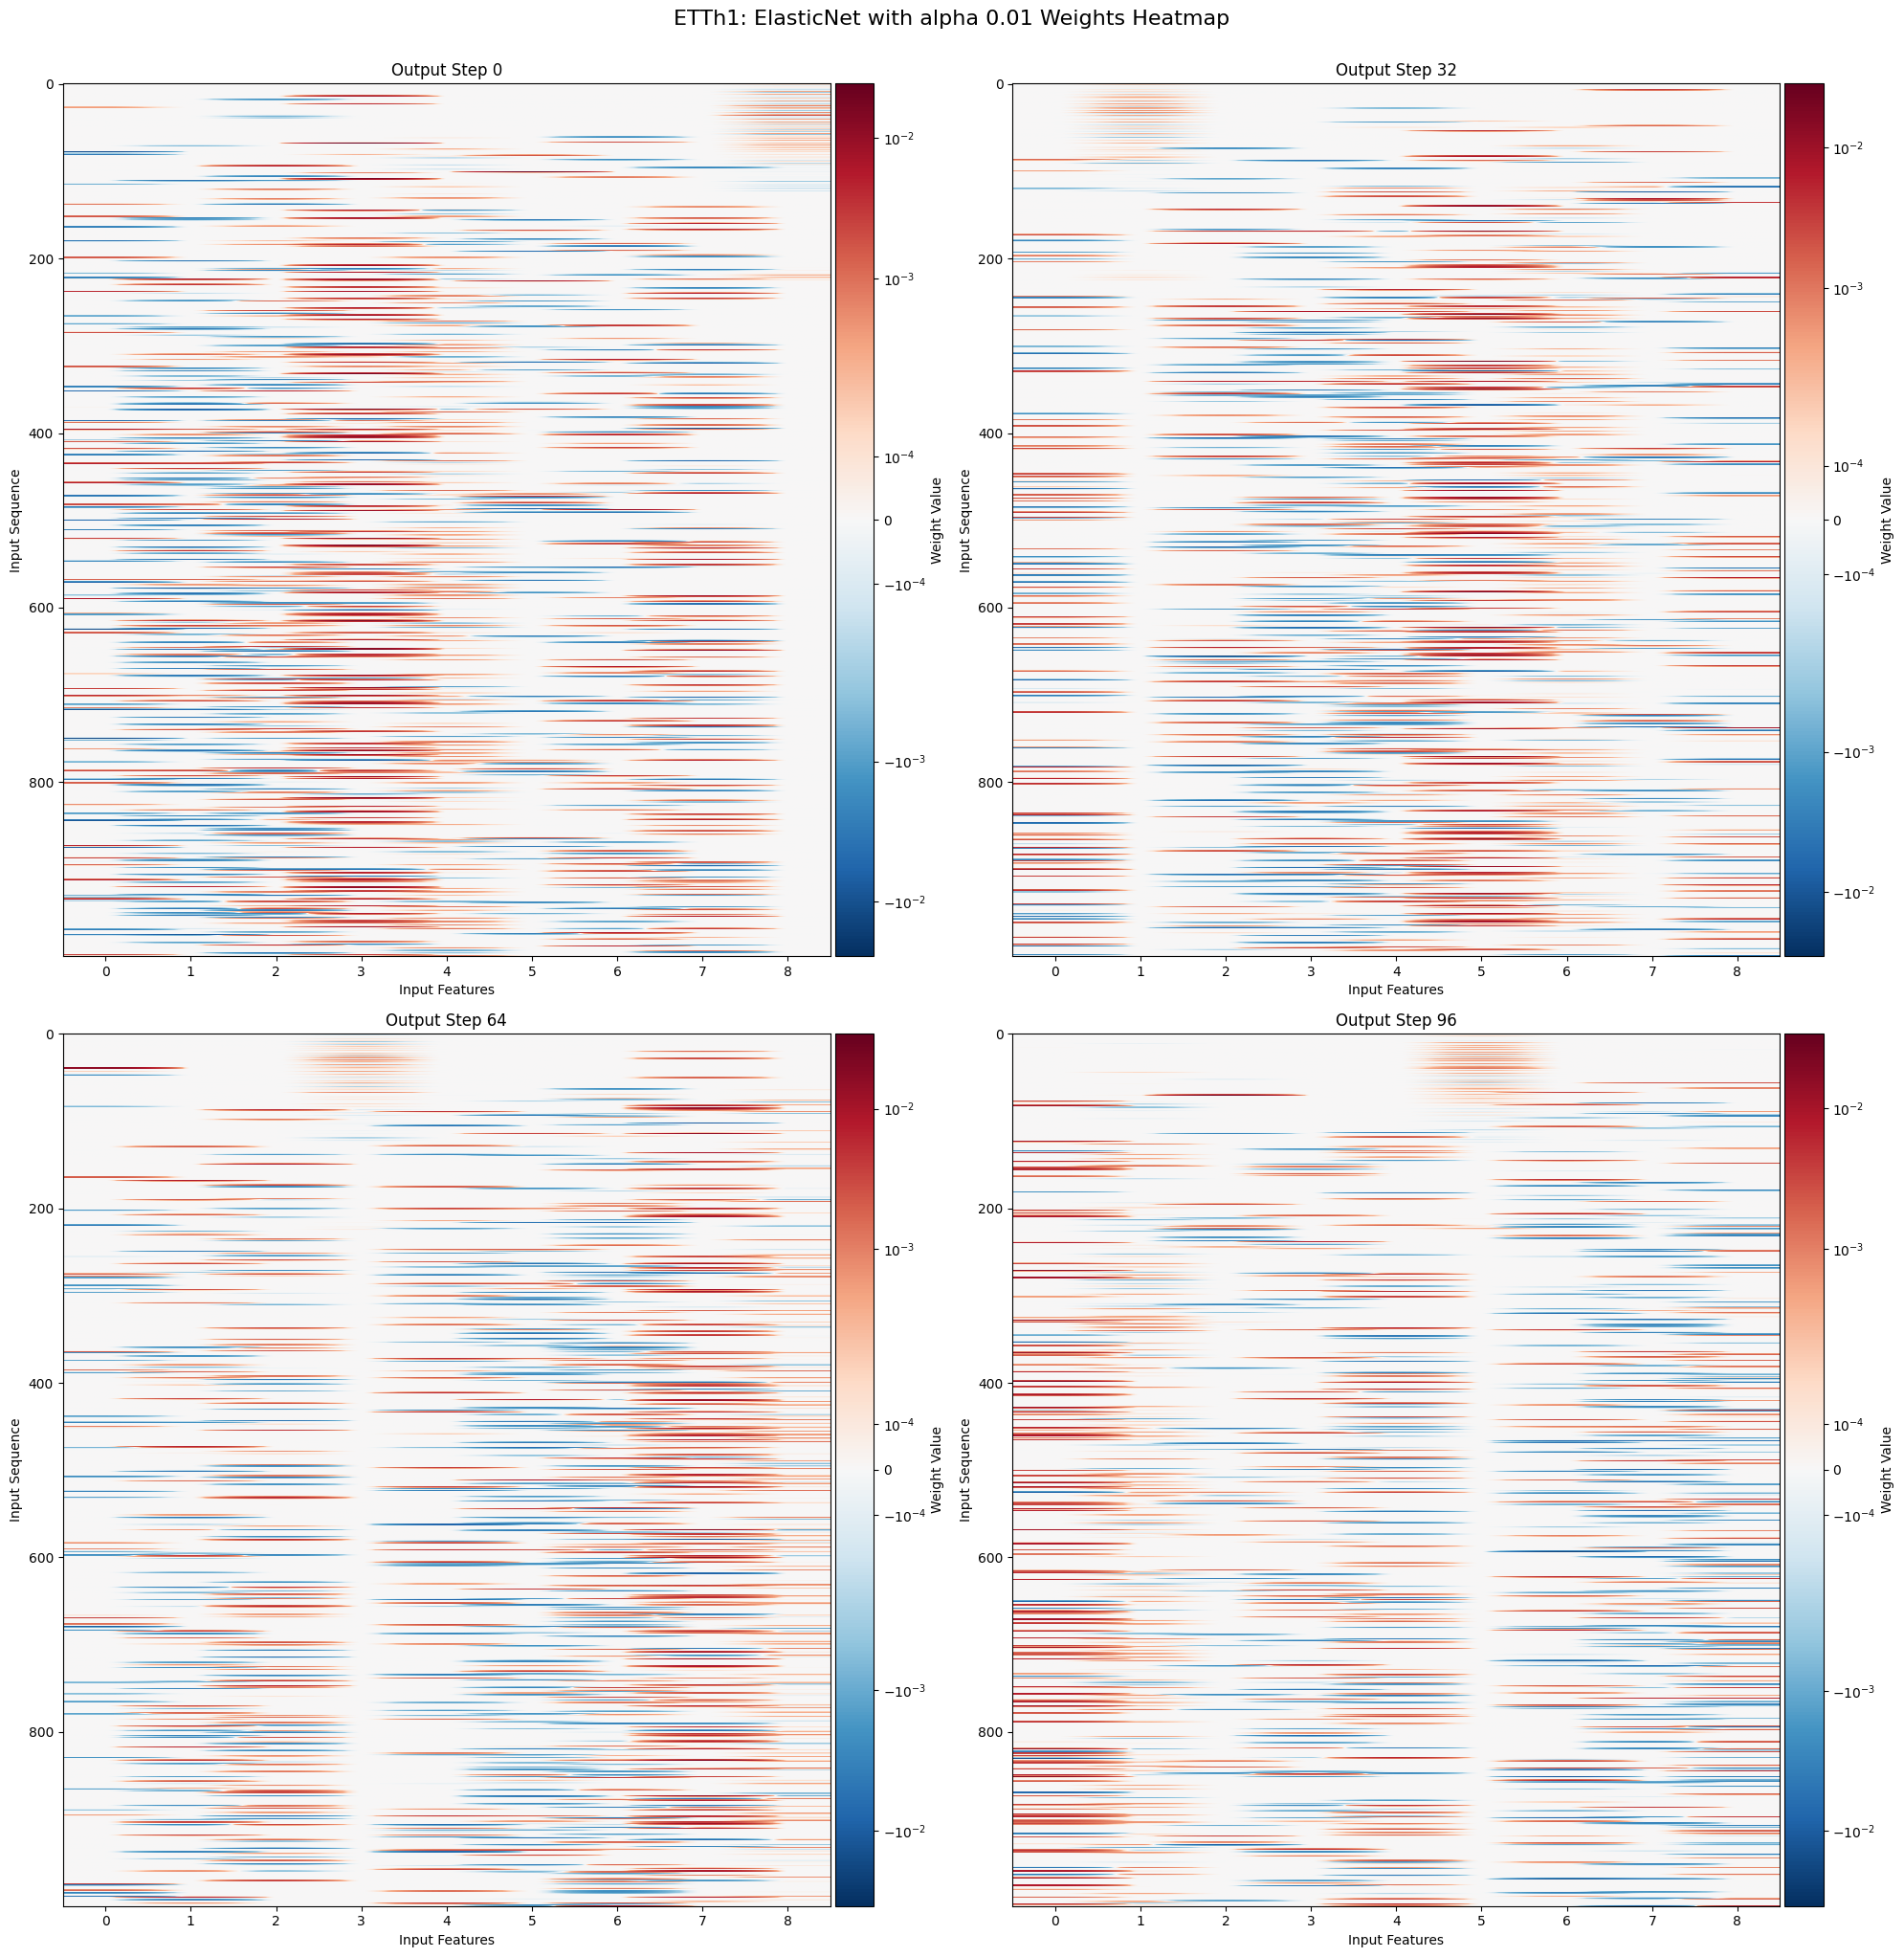

In [19]:
alpha = 1e-2
start_time = time.time()
weights, bias, model = elasticnet_regression_weights_and_model(X_train, y_train, alpha = alpha)
end_time = time.time()
preds = model.predict(X_test.reshape(X_test.shape[0], -1))
print('r2 score:', r2_score(y_true=y_test.flatten(), y_pred=preds.flatten()), 'took', end_time - start_time, 'seconds')

plot_weights(weights, f'ETTh1: ElasticNet with alpha {alpha}')

## BTC volume

In [20]:
class MinMaxScaler:
    def __init__(self, feature_axis=None, minmax_range=(0, 1)):
        """
        Initialize the MinMaxScaler.
        Args:
        feature_axis (int, optional): The axis that represents the feature dimension if applicable.
                                      Use only for 3D data to specify which axis is the feature axis.
                                      Default is None, automatically managed based on data dimensions.
        """
        self.feature_axis = feature_axis
        self.min_ = None
        self.max_ = None
        self.scale_ = None
        self.minmax_range = minmax_range # Default range for scaling (min, max)

    def fit(self, X):
        """
        Fit the scaler to the data based on its dimensionality.
        Args:
        X (np.array): The data to fit the scaler on.
        """
        if X.ndim == 3 and self.feature_axis is not None:  # 3D data
            axis = tuple(i for i in range(X.ndim) if i != self.feature_axis)
            self.min_ = np.min(X, axis=axis)
            self.max_ = np.max(X, axis=axis)
        elif X.ndim == 2:  # 2D data
            self.min_ = np.min(X, axis=0)
            self.max_ = np.max(X, axis=0)
        elif X.ndim == 1:  # 1D data
            self.min_ = np.min(X)
            self.max_ = np.max(X)
        else:
            raise ValueError("Data must be 1D, 2D, or 3D.")

        self.scale_ = self.max_ - self.min_
        return self

    def transform(self, X):
        """
        Transform the data using the fitted scaler.
        Args:
        X (np.array): The data to transform.
        Returns:
        np.array: The scaled data.
        """
        X_scaled = (X - self.min_) / self.scale_
        X_scaled = X_scaled * (self.minmax_range[1] - self.minmax_range[0]) + self.minmax_range[0]
        return X_scaled

    def fit_transform(self, X):
        """
        Fit to data, then transform it.
        Args:
        X (np.array): The data to fit and transform.
        Returns:
        np.array: The scaled data.
        """
        return self.fit(X).transform(X)

    def inverse_transform(self, X_scaled):
        """
        Inverse transform the scaled data to original data.
        Args:
        X_scaled (np.array): The scaled data to inverse transform.
        Returns:
        np.array: The original data scale.
        """
        X = (X_scaled - self.minmax_range[0]) / (self.minmax_range[1] - self.minmax_range[0])
        X = X * self.scale_ + self.min_
        return X

def generate_data(df, sequence_length, n_ahead = 1):
    #Case without known inputs
    scaler_df = df.copy().shift(n_ahead).rolling(24 * 14).median()
    tmp_df = df.copy() / scaler_df
    tmp_df = tmp_df.iloc[24 * 14 + n_ahead:].fillna(0.)
    scaler_df = scaler_df.iloc[24 * 14 + n_ahead:].fillna(0.)
    def prepare_sequences(df, scaler_df, n_history, n_future):
        X, y, y_scaler = [], [], []
        num_features = df.shape[1]
        
        # Iterate through the DataFrame to create sequences
        for i in range(n_history, len(df) - n_future + 1):
            # Extract the sequence of past observations
            X.append(df.iloc[i - n_history:i].values)
            # Extract the future values of the first column
            y.append(df.iloc[i:i + n_future,0:1].values)
            y_scaler.append(scaler_df.iloc[i:i + n_future,0:1].values)
        
        X, y, y_scaler = np.array(X), np.array(y), np.array(y_scaler)
        return X, y, y_scaler
    
    # Prepare sequences
    X, y, y_scaler = prepare_sequences(tmp_df, scaler_df, sequence_length, n_ahead)
    
    # Split the dataset into training and testing sets
    train_test_separation = int(len(X) * 0.8)
    X_train_unscaled, X_test_unscaled = X[:train_test_separation], X[train_test_separation:]
    y_train_unscaled, y_test_unscaled = y[:train_test_separation], y[train_test_separation:]
    y_scaler_train, y_scaler_test = y_scaler[:train_test_separation], y_scaler[train_test_separation:]
    
    # Generate the data
    X_scaler = MinMaxScaler(feature_axis=2)
    X_train = X_scaler.fit_transform(X_train_unscaled)
    X_test = X_scaler.transform(X_test_unscaled)
    
    y_scaler = MinMaxScaler(feature_axis=2)
    y_train = y_scaler.fit_transform(y_train_unscaled)
    y_test = y_scaler.transform(y_test_unscaled)
    
    y_train = y_train.reshape(y_train.shape[0], -1) 
    y_test = y_test.reshape(y_test.shape[0], -1)
    X_train, X_test = np.nan_to_num(X_train), np.nan_to_num(X_test) 
    return X_train, y_train, X_test, y_test 


In [21]:
df = pd.read_parquet('/workspace/data.parquet')
df = df[(df.index >= pd.Timestamp('2020-01-01')) & (df.index < pd.Timestamp('2023-01-01'))]
assets = ['BTC', 'ETH', 'ADA', 'XMR', 'EOS', 'MATIC', 'TRX', 'FTM', 'BNB', 'XLM', 'ENJ', 'CHZ', 'BUSD', 'ATOM', 'LINK', 'ETC', 'XRP', 'BCH', 'LTC']
df = df[[c for c in df.columns if 'quote asset volume' in c and any(asset in c for asset in assets)]]
df.columns = [c.replace(' quote asset volume', '') for c in df.columns]
df['hour'] = df.reset_index()['group'].apply(lambda x: x.hour).values
df['dayofweek'] = df.reset_index()['group'].apply(lambda x: x.dayofweek).values
generate = lambda sequence_length, n_ahead: generate_data(df = df, sequence_length = sequence_length, n_ahead = n_ahead)
sequence_length, n_ahead = 200, 128
X_train, y_train, X_test, y_test = generate(sequence_length, n_ahead) 
y_train, y_test = np.expand_dims(y_train, axis=-1), np.expand_dims(y_test, axis=-1)

160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step  
r2 score: 0.10314804213186113 took 9.908783912658691 seconds


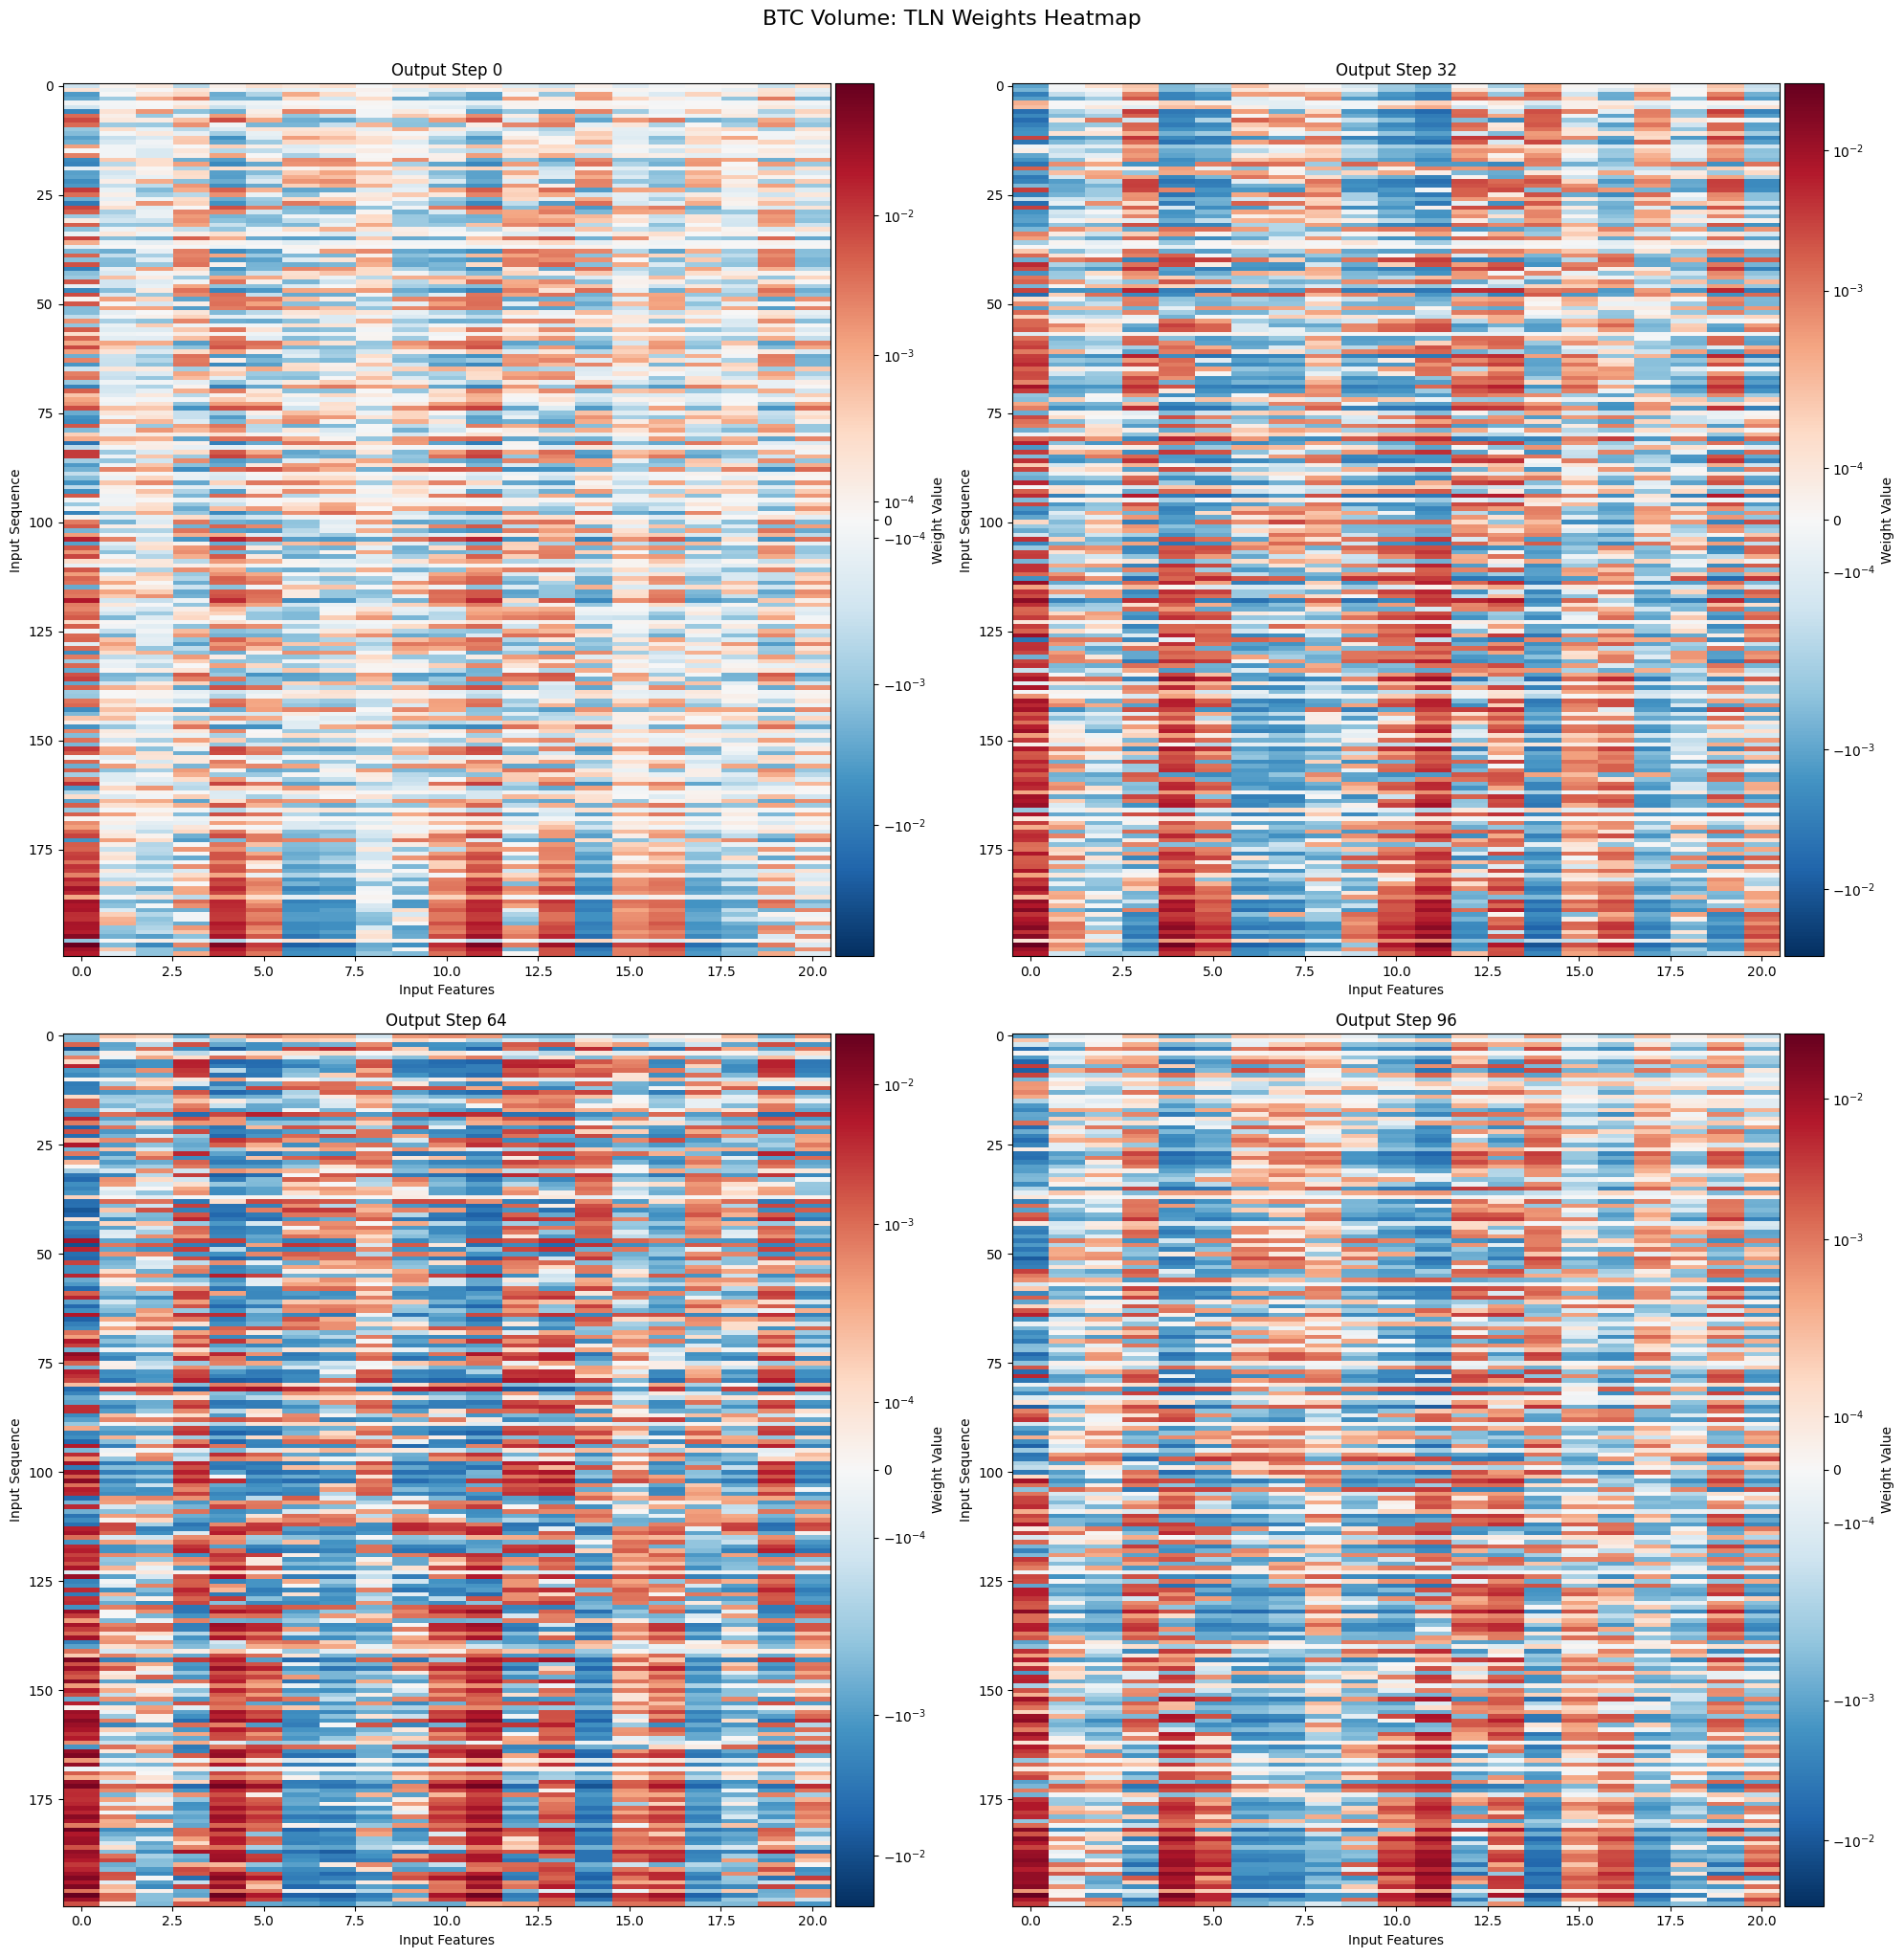

In [22]:
model = TLN(
    output_len = n_ahead,
    output_features = 1,
    flatten_output = False,
    hidden_layers = 2,
    use_convolution = True,
)
model.build(X_train.shape)

optimizer = keras.optimizers.Adam(0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error', jit_compile=True)
start_time = time.time()
history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=N_MAX_EPOCHS, validation_split=0.2, callbacks=callbacks(), shuffle=True, verbose=False)
end_time = time.time()
preds = model.predict(X_test)
print('r2 score:', r2_score(y_true=y_test.flatten(), y_pred=preds.flatten()), 'took', end_time - start_time, 'seconds')
weights, bias = model.compute_linear_equivalent_weights()
plot_weights(weights, 'BTC Volume: TLN')

r2 score: -0.03827444885152165 took 13.1631760597229 seconds


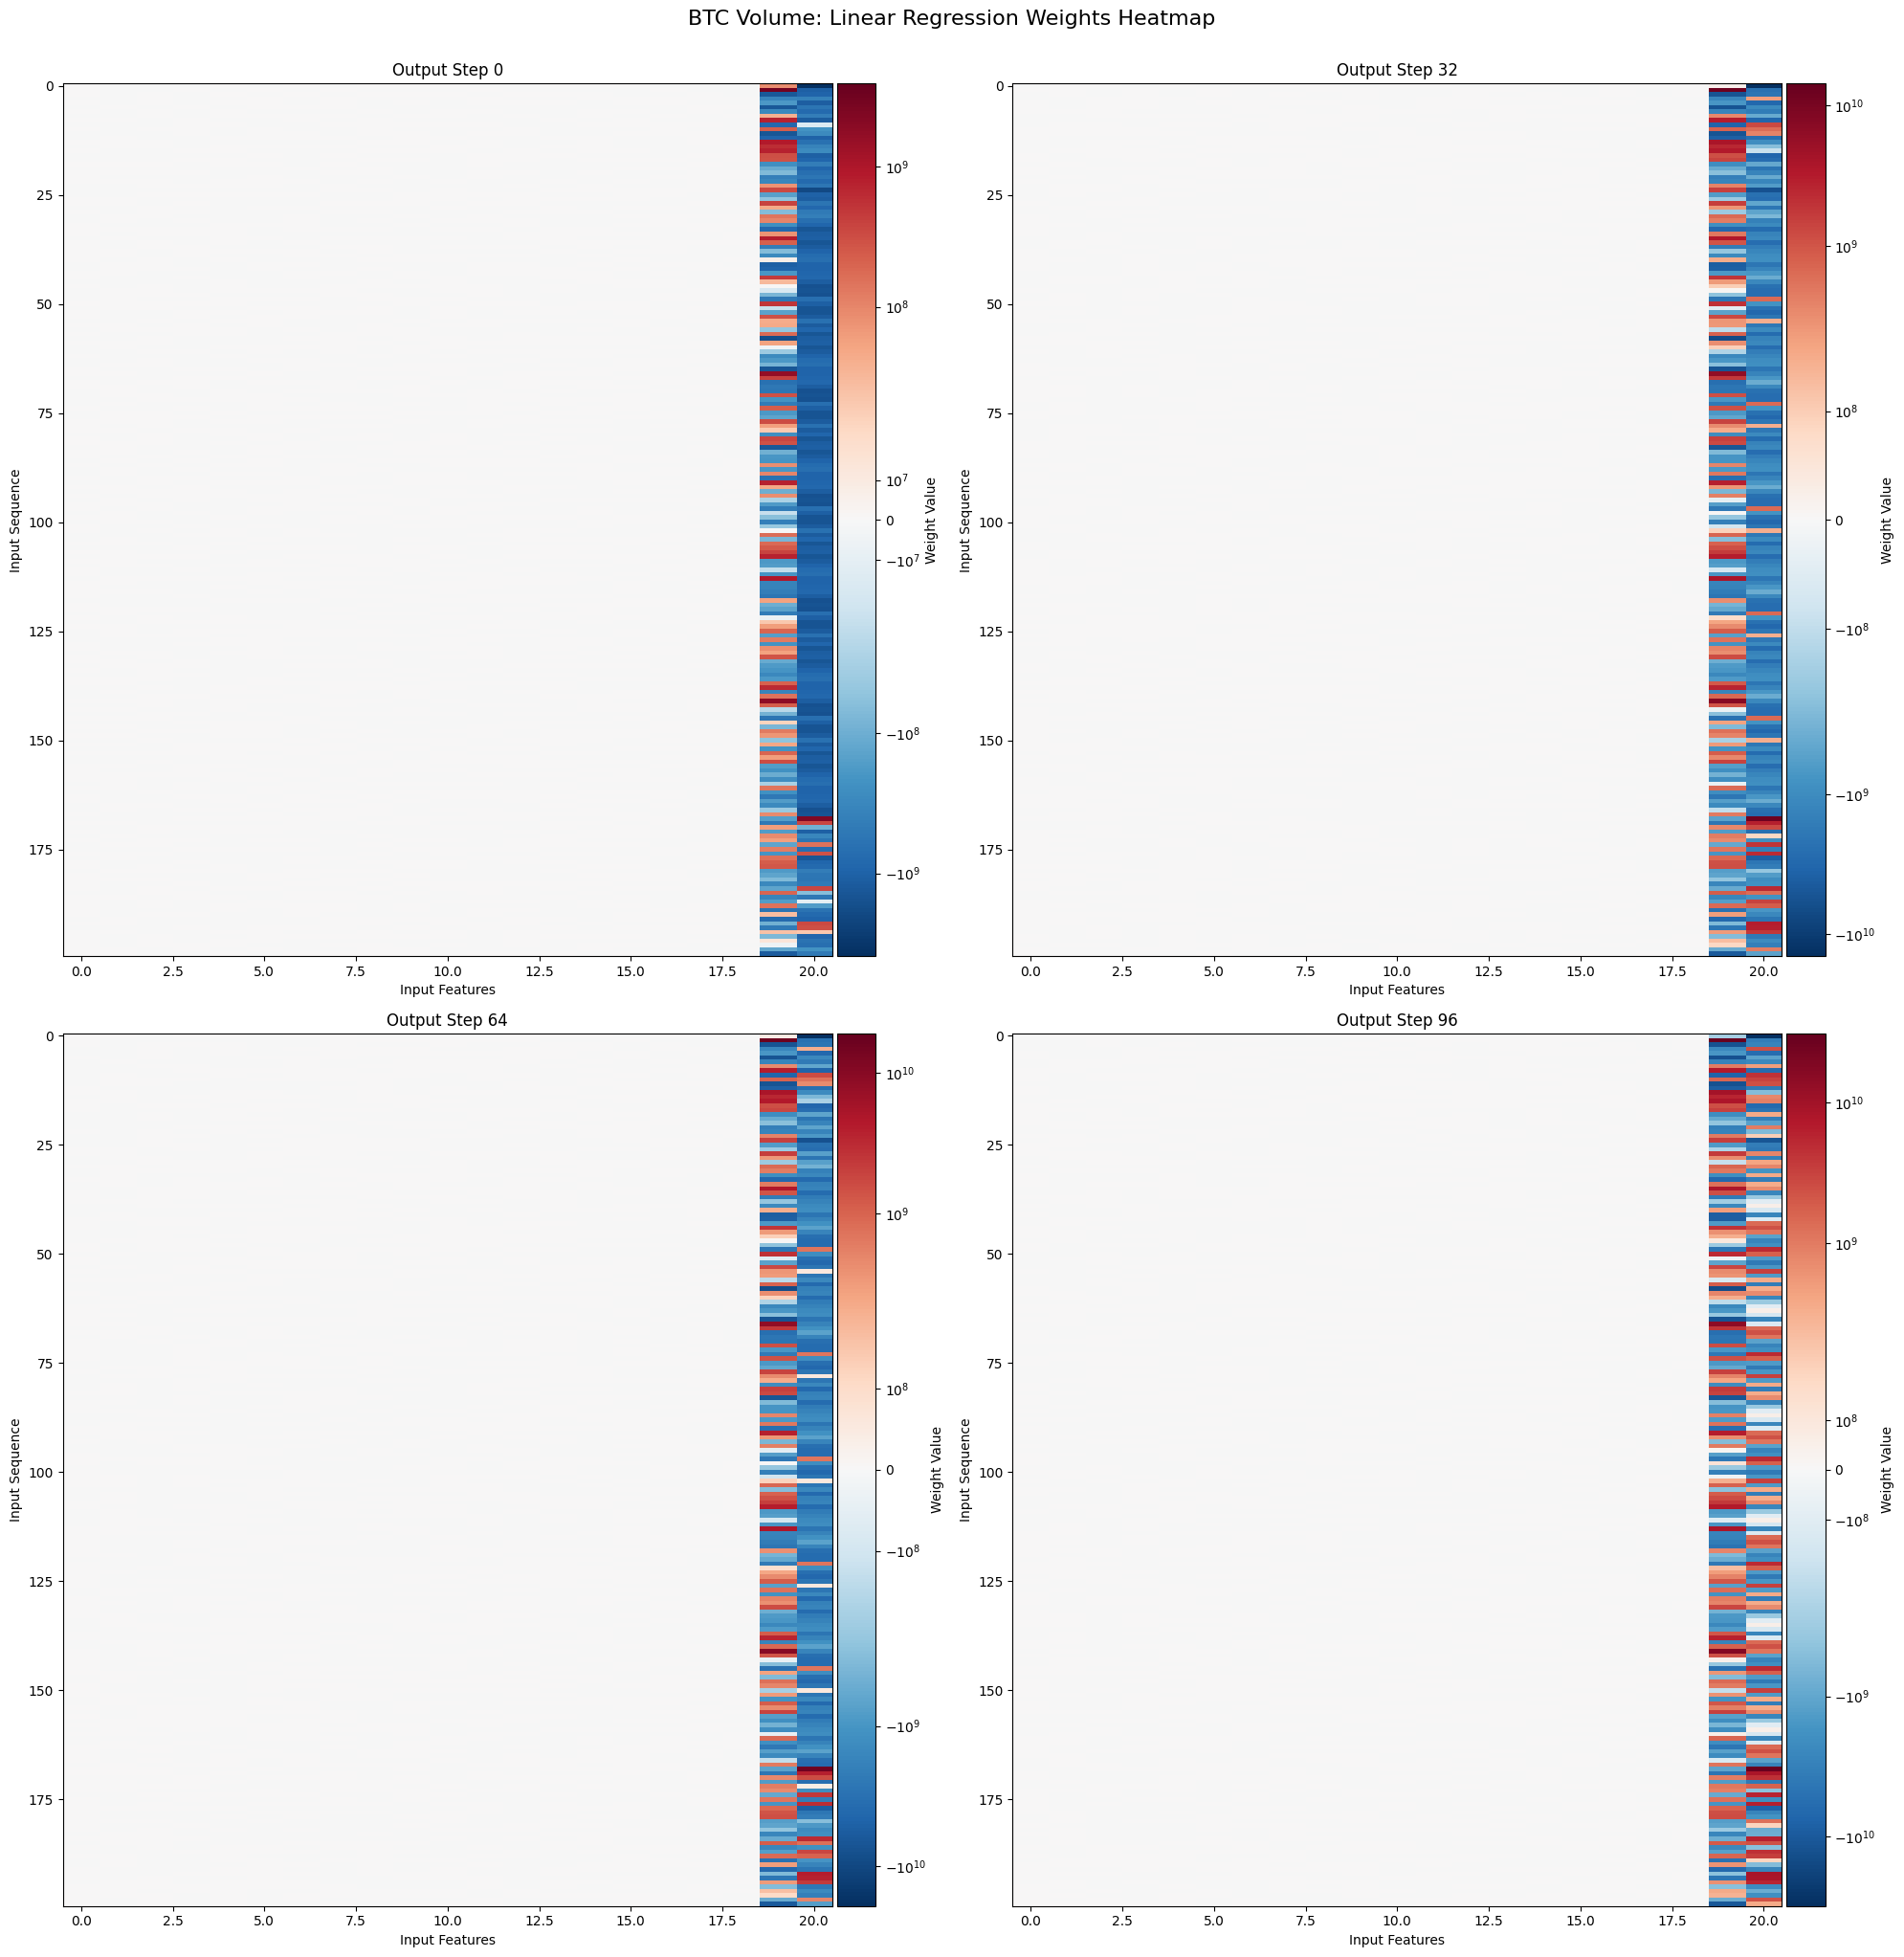

In [23]:
start_time = time.time()
weights, bias, model = linear_regression_weights_and_model(X_train, y_train)
end_time = time.time()
preds = model.predict(X_test.reshape(X_test.shape[0], -1))
print('r2 score:', r2_score(y_true=y_test.flatten(), y_pred=preds.flatten()), 'took', end_time - start_time, 'seconds')

plot_weights(weights, 'BTC Volume: Linear Regression')

r2 score: 0.018302580582901684 took 0.9026544094085693 seconds


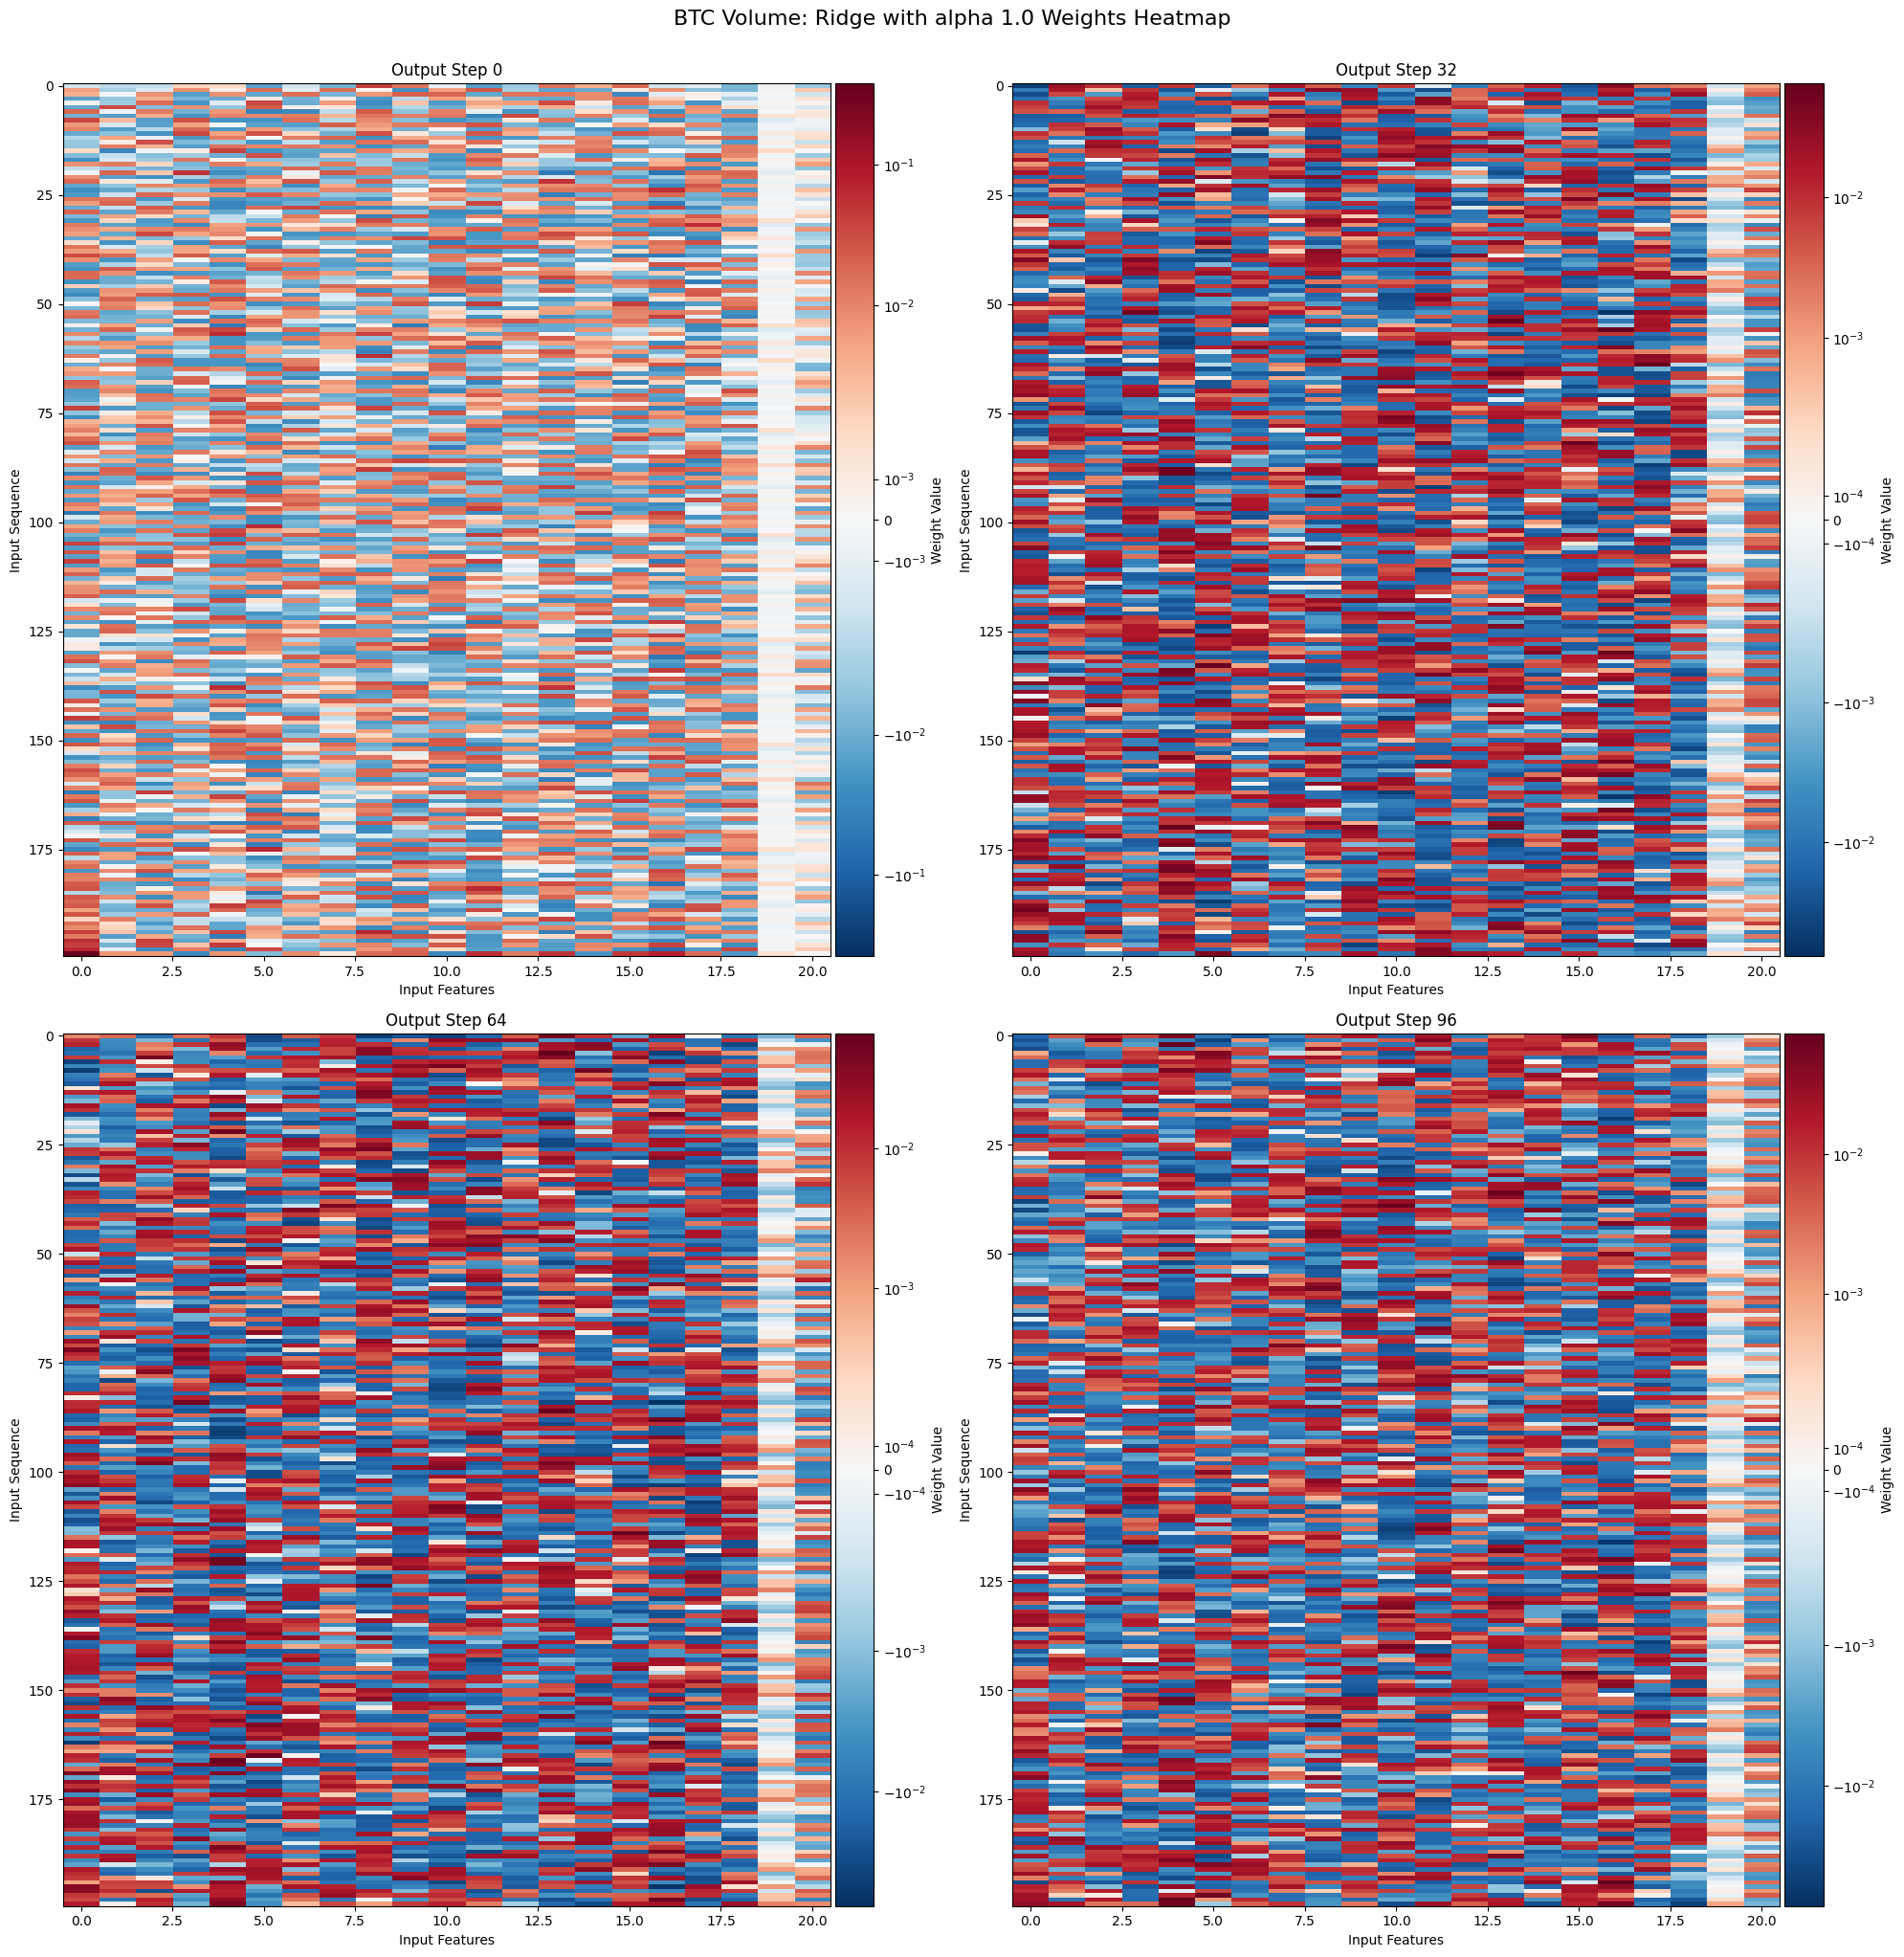

In [24]:
alpha = 1.
start_time = time.time()
weights, bias, model = ridge_regression_weights_and_model(X_train, y_train, alpha = alpha)
end_time = time.time()
preds = model.predict(X_test.reshape(X_test.shape[0], -1))
print('r2 score:', r2_score(y_true=y_test.flatten(), y_pred=preds.flatten()), 'took', end_time - start_time, 'seconds')

plot_weights(weights, f'BTC Volume: Ridge with alpha {alpha}')

r2 score: 0.061247385768299134 took 3.0559654235839844 seconds


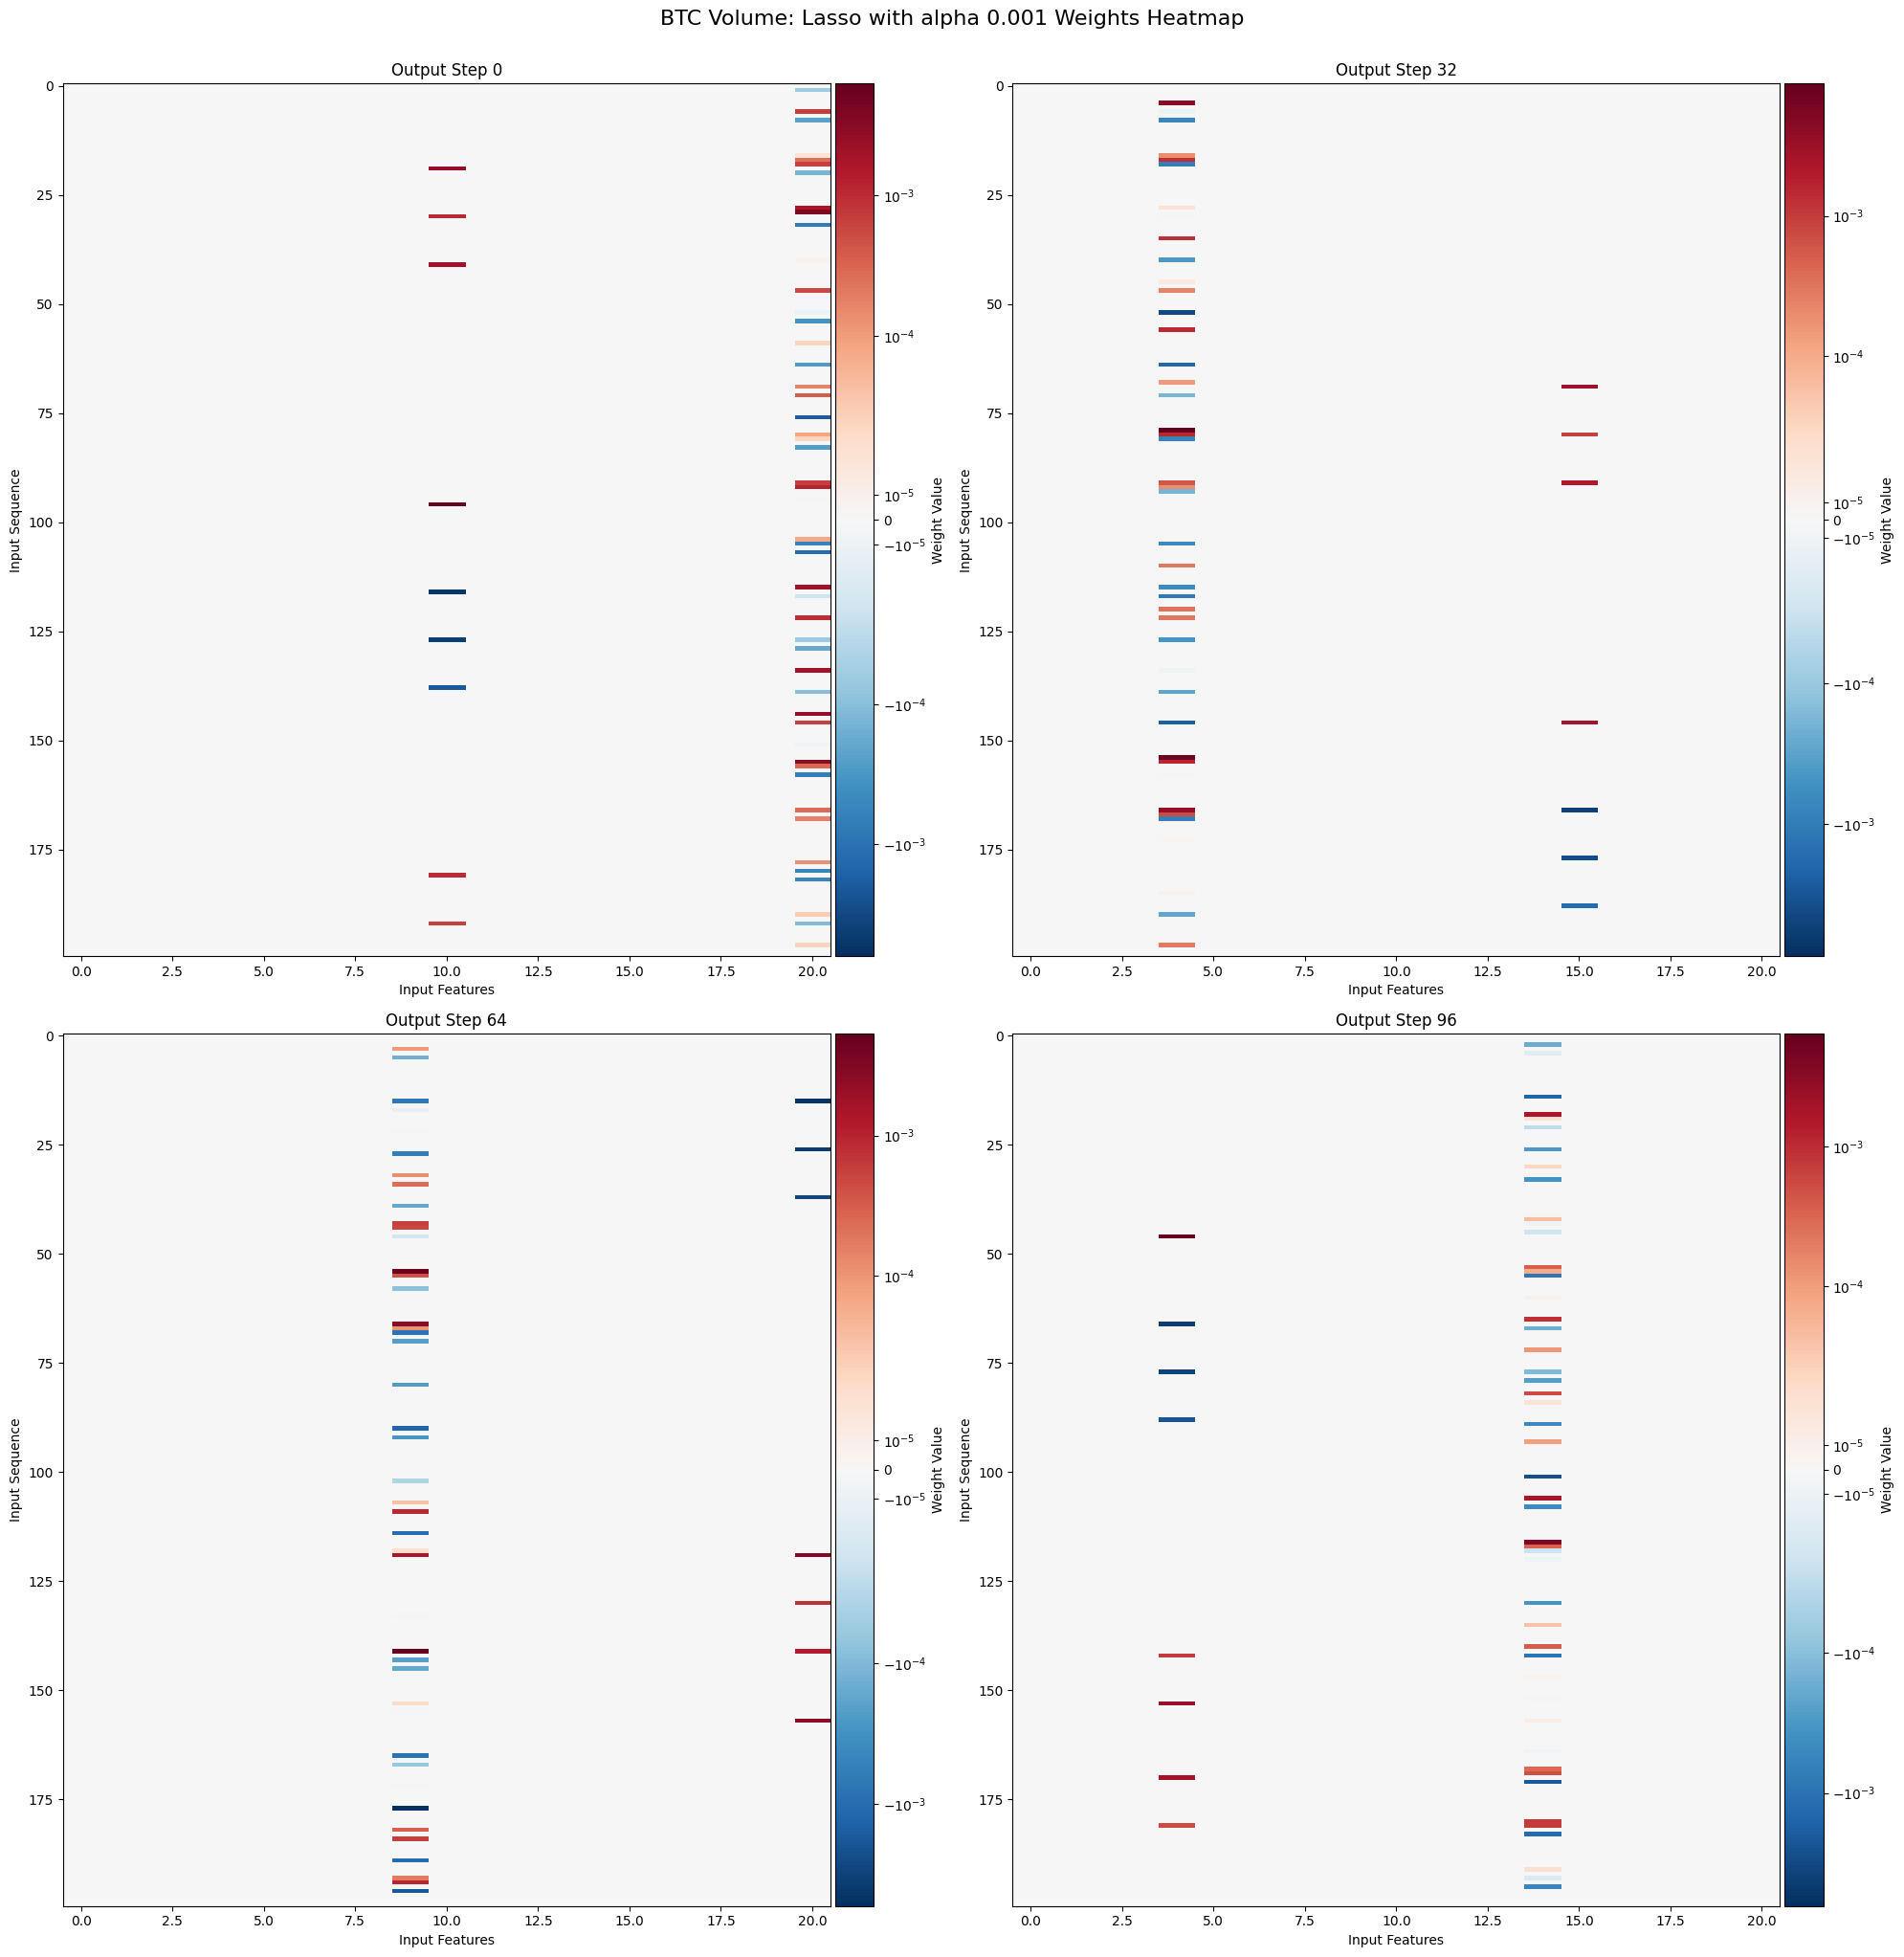

In [25]:
alpha = 1e-3
start_time = time.time()
weights, bias, model = lasso_regression_weights_and_model(X_train, y_train, alpha = alpha)
end_time = time.time()
preds = model.predict(X_test.reshape(X_test.shape[0], -1))
print('r2 score:', r2_score(y_true=y_test.flatten(), y_pred=preds.flatten()), 'took', end_time - start_time, 'seconds')

plot_weights(weights, f'BTC Volume: Lasso with alpha {alpha}')

r2 score: 0.08201623742212127 took 10.776810884475708 seconds


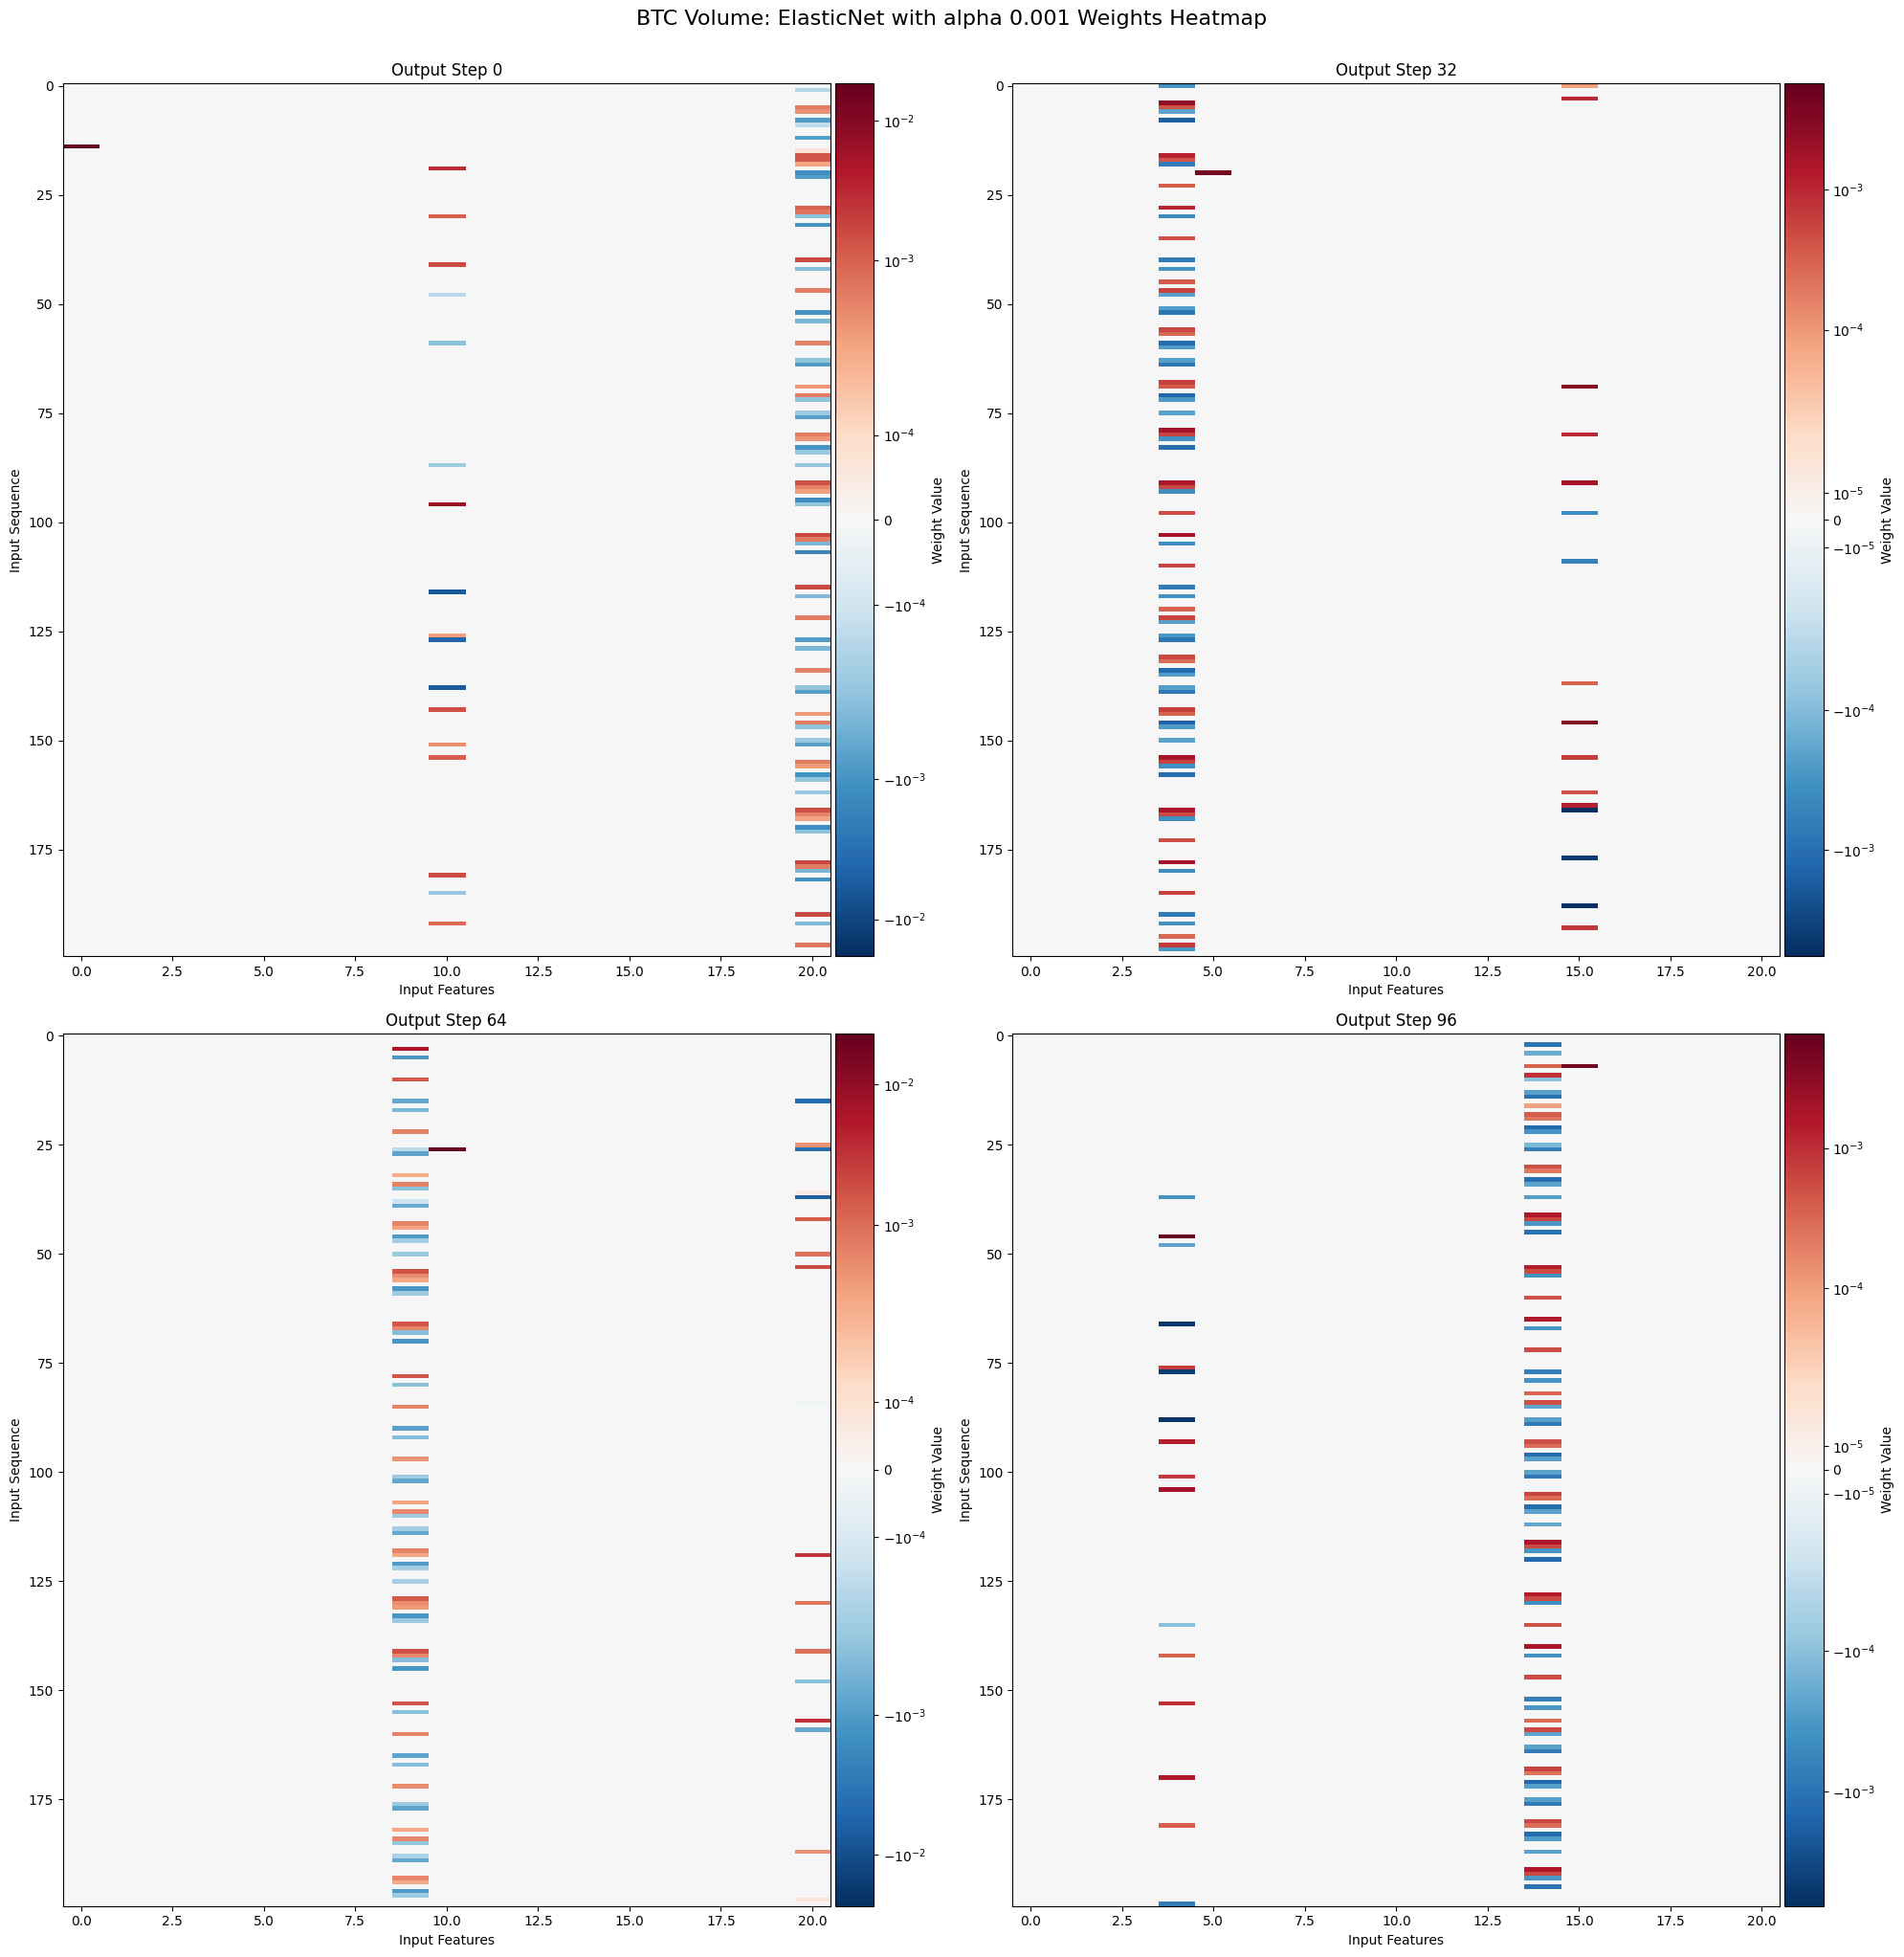

In [26]:
alpha = 1e-3
start_time = time.time()
weights, bias, model = elasticnet_regression_weights_and_model(X_train, y_train, alpha = alpha)
end_time = time.time()
preds = model.predict(X_test.reshape(X_test.shape[0], -1))
print('r2 score:', r2_score(y_true=y_test.flatten(), y_pred=preds.flatten()), 'took', end_time - start_time, 'seconds')

plot_weights(weights, f'BTC Volume: ElasticNet with alpha {alpha}')